# DSCI552 HW2

by Kartik Balodi  
Github Username: kartikbalodi  
USC ID: 5317465471

**1. Combined Cycle Power Plant Data Set**  
  
The dataset contains data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of **hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V)** to predict the **net hourly electrical energy output (EP)** of the plant.

Preamble on data:  
The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is collected from and has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

**(a) Download the Combined Cycle Power Plant data* from:
https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant**
  
***There are five sheets in the data. All of them are shuffled versions of the same dataset. Work with Sheet 1.**

In [1]:
import pandas as pd
import numpy as np
import random

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ccpp_df = pd.read_excel("../data/CCPP/Folds5x2_pp.xlsx", sheet_name='Sheet1')
ccpp_df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

No issues with data since no null values are present in this spreadsheet, so we can proceed without having to concern ourselves too much with any further preprocessing.  
  
We will rename the columns accordingly to make the data more readable/interpretable

In [3]:
col_names = {'AT':'Ambient Temperature (AT)', 'V':'Exhaust Vacuum (V)', 'AP':'Ambient Pressure (AP)', 
                               'RH':'Relative Humidity (RH)', 'PE':'Energy Output (EP)'}
ccpp_df = ccpp_df.rename(columns=col_names)
ccpp_df.head()

Ambient Temperature (AT)  Exhaust Vacuum (V)  Ambient Pressure (AP)  \
0                     14.96               41.76                1024.07   
1                     25.18               62.96                1020.04   
2                      5.11               39.40                1012.16   
3                     20.86               57.32                1010.24   
4                     10.82               37.50                1009.23   

   Relative Humidity (RH)  Energy Output (EP)  
0                   73.17              463.26  
1                   59.08              444.37  
2                   92.14              488.56  
3                   76.64              446.48  
4                   96.62              473.90

**(b) Exploring the data:**  
**- i. How many rows are in this data set? How many columns? What do the rows and columns represent?**

In [4]:
row, col = ccpp_df.shape
print("Number of rows:", row)
print("Number of columns:", col)

Number of rows: 9568
Number of columns: 5


From https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant: 

Features consist of hourly average ambient variables:  
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
  
The above four features, based on the readme file of the data folder, are used to predict the following dependent feature:
- Net hourly electrical energy output (EP) 420.26-495.76 MW  



The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

**- ii. Make pairwise scatterplots of all the variables in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.**

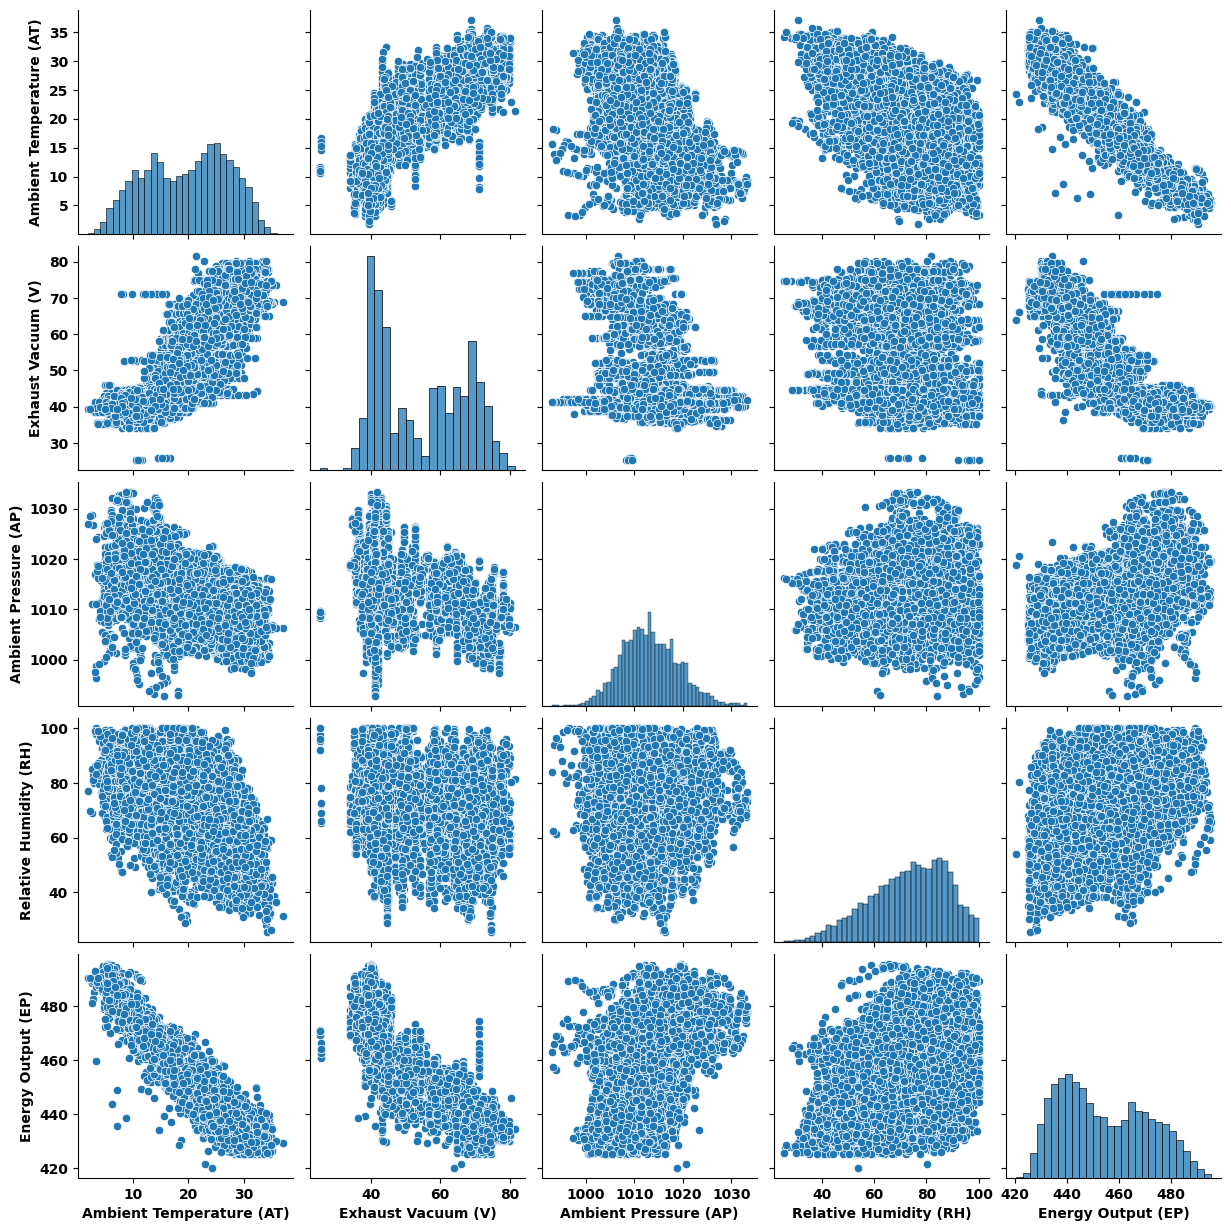

In [5]:
sns.pairplot(ccpp_df)
plt.show()

First of all, we observe that none of the features/variables are normally distributed. EP, AT and V seem to have some form of bimodal distribution, whereas AP and RH have a unimodal and skewed distribution. AP seems to have a longer right-tail while RH has a longer left-tail.  
  
Since EP is the dependent/y-variable feature, let's start with comparing the scatterplots of EP against the independent variables and work our way upwards. It seems that AT and V show some clear form of negative correlation with respect to EP, whereas there doesn't seem to be any obvious trend for AP and RH.

RH doesn't seem to exhibit any clear trend with V and AP, and while this seems to be the case with respect to AT as well, one could argue of a very slight/weak negative correlation between RH and AT.

AP seems to exhibit a weak trend for negative correlation with respect to AT and V.

V seems to be positively correlated with respect to AT.

**- iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table.**

Pandas has an inbuilt method called describe, which gives the breakdown of the variables. The variables don't match all of the instructions required for the prompt, so we'll manipulate the dataframe returned by describe to give us a table in the order given as per the prompt above.

In [6]:
ccpp_df.describe()

Ambient Temperature (AT)  Exhaust Vacuum (V)  Ambient Pressure (AP)  \
count               9568.000000         9568.000000            9568.000000   
mean                  19.651231           54.305804            1013.259078   
std                    7.452473           12.707893               5.938784   
min                    1.810000           25.360000             992.890000   
25%                   13.510000           41.740000            1009.100000   
50%                   20.345000           52.080000            1012.940000   
75%                   25.720000           66.540000            1017.260000   
max                   37.110000           81.560000            1033.300000   

       Relative Humidity (RH)  Energy Output (EP)  
count             9568.000000         9568.000000  
mean                73.308978          454.365009  
std                 14.600269           17.066995  
min                 25.560000          420.260000  
25%                 63.327500          439.750000  
50%                 74.975000          451.550000  
75%                 84.830000          468.430000  
max                100.160000          495.760000

In [7]:
desc_df = ccpp_df.describe()
desc_df = desc_df.drop(['count','std'],axis=0).rename(index={'50%':'median', '25%':'first quartile', 
                                                                         '75%':'third quartile'})
r = desc_df.xs('max') - desc_df.xs('min')
r.name = 'range'
iqr = desc_df.xs('third quartile') - desc_df.xs('first quartile')
iqr.name = 'interquartile range'

desc_df = pd.concat([desc_df,pd.concat([r,iqr],axis=1).transpose()]).drop(['min','max']).reindex(
    ['mean','median','range','first quartile','third quartile','interquartile range'])
print("Summarized Table: ")
desc_df

Summarized Table: 


Ambient Temperature (AT)  Exhaust Vacuum (V)  \
mean                                19.651231           54.305804   
median                              20.345000           52.080000   
range                               35.300000           56.200000   
first quartile                      13.510000           41.740000   
third quartile                      25.720000           66.540000   
interquartile range                 12.210000           24.800000   

                     Ambient Pressure (AP)  Relative Humidity (RH)  \
mean                           1013.259078               73.308978   
median                         1012.940000               74.975000   
range                            40.410000               74.600000   
first quartile                 1009.100000               63.327500   
third quartile                 1017.260000               84.830000   
interquartile range               8.160000               21.502500   

                     Energy Output (EP)  
mean                         454.365009  
median                       451.550000  
range                         75.500000  
first quartile               439.750000  
third quartile               468.430000  
interquartile range           28.680000

**(c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?**


_From piazza post 245, 277 & 301 for outlier detection:  
Check out Cooks distance, Studentized reisduals, influence and leverage.
When reviewing a box plot, an outlier is defined as a data point that is located outside the whiskers of the box plot. Cook’s Distance is commonly used to estimate the influence of a data point when performing a least-squares regression analysis. This is more appropriate for linear regression analysis as it determines outliers based on the influence of each point on the regression line._  

Resources Consulted:  
- https://en.wikipedia.org/wiki/Cook%27s_distance
- https://www.mit.edu/~6.s085/notes/lecture4.pdf
- https://cran.r-project.org/web/packages/olsrr/vignettes/influence_measures.html
- https://www.statology.org/studentized-residuals-in-python/
- https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html
- https://www.statology.org/residual-plot-python/
- https://www.statology.org/cooks-distance-python/

**_EP against AT_**

In [8]:
Y = ccpp_df['Energy Output (EP)'].tolist()
X = ccpp_df['Ambient Temperature (AT)'].tolist()
X = sm.add_constant(X)
model_AT = sm.OLS(endog=Y,exog=X).fit()

print(model_AT.summary(xname=['const','Ambient Temperature (AT)']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:07:21   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

eval_env: 1


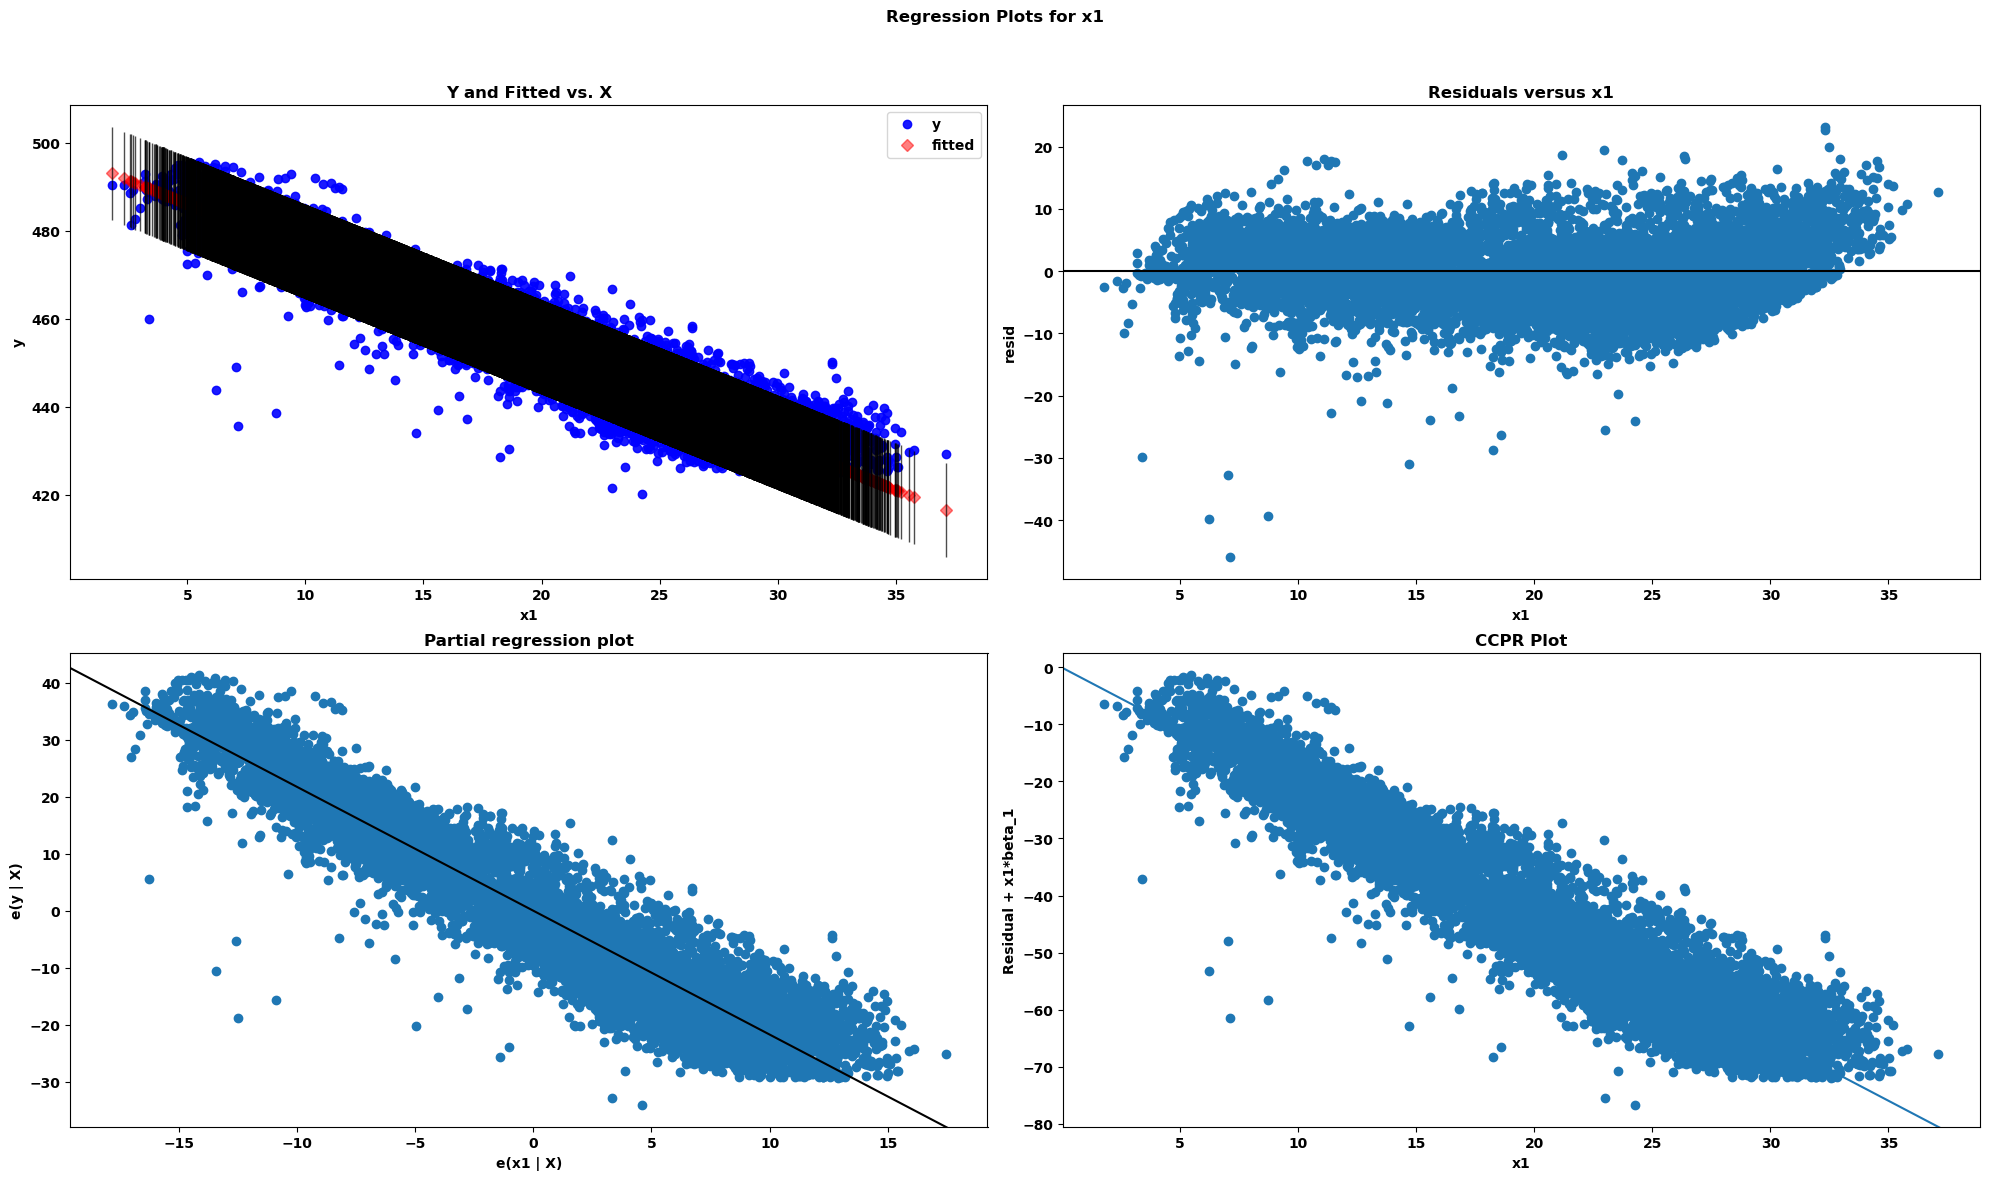

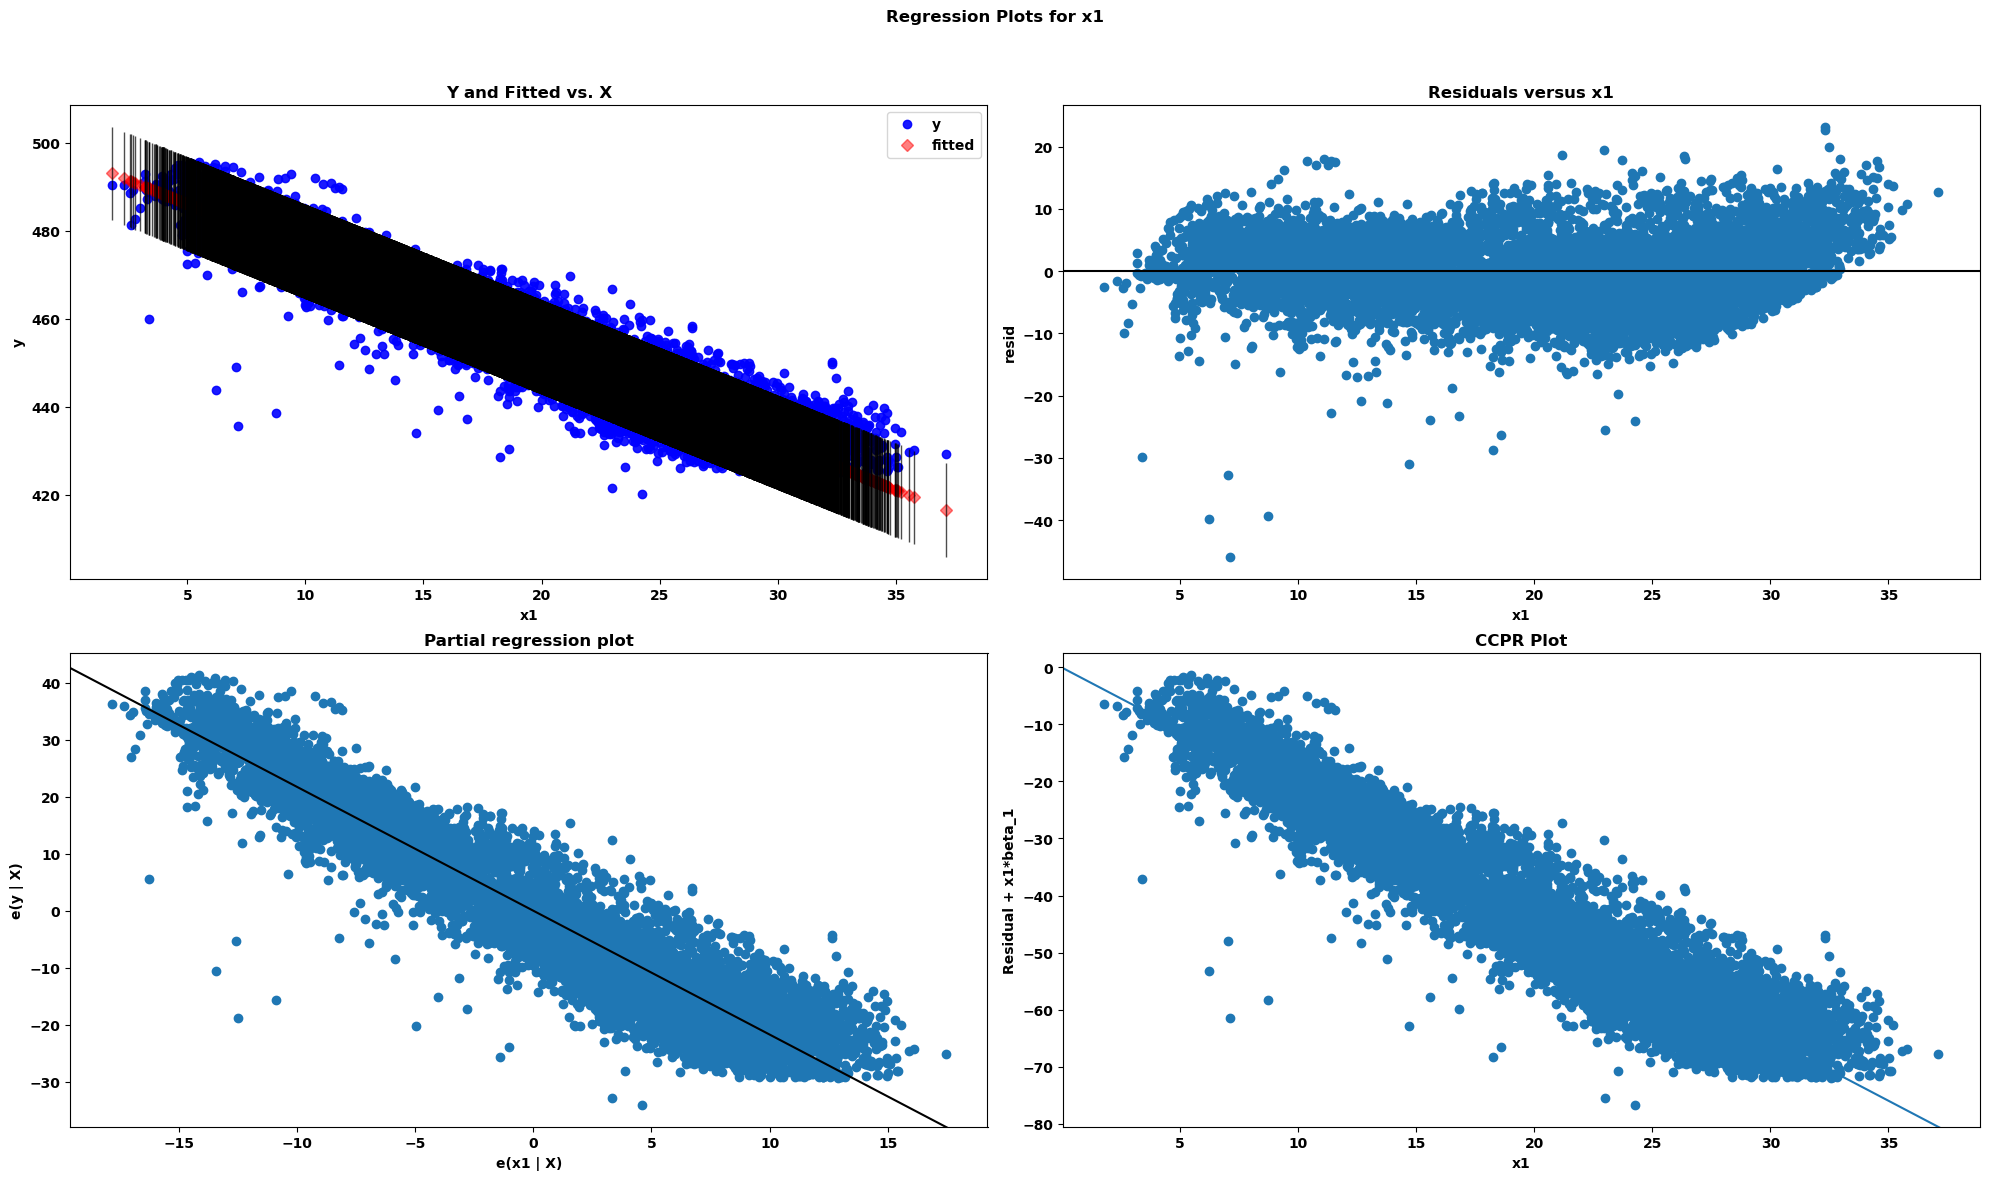

In [9]:
plt.close()
fig = plt.figure(figsize=(20,12))

#produce regression plots
sm.graphics.plot_regress_exog(model_AT, 'x1', fig=fig)

We notice the huge sample size (n>30). When testing for statistical significance, we use a student's t-distribution, which over large sample sizes approximates a normal distribution, more specifically a standard normal distribution Z~N(0,1). Our null hypothesis is testing for whether our excess return is significant, i.e. H0 = 0. Consequently, the alternative is H1 != 0. At a 5% significance level, for a two-tailed z-test, the absolute value of the t-stat must be >= 1.96 for our results to be considered statistically significant, i.e. reject the null hypothesis.

The p-values observed are extremely small, |t-stats| >>> 2, therefore at the alpha=5%, (1-alpha)% confidence level we reject the null hypothesis and conclude that Ambient Temperature (AT) has a statistically significant effect on Energy Output (EP). Note the R^2 value is 0.899, which means 89.9% of the variability could be explained by a simple fit against AT.

Our residual analysis (note the diagram labelled residual vs x1 (where x1 = AT)), shows that the residuals are fairly evenly distributed across the range of ATs apart from a skewed residual when AT>=30, suggesting that our linear regression has successfully captured a good portion of the trends, which is what we expected to begin with from the pairsplots earlier.

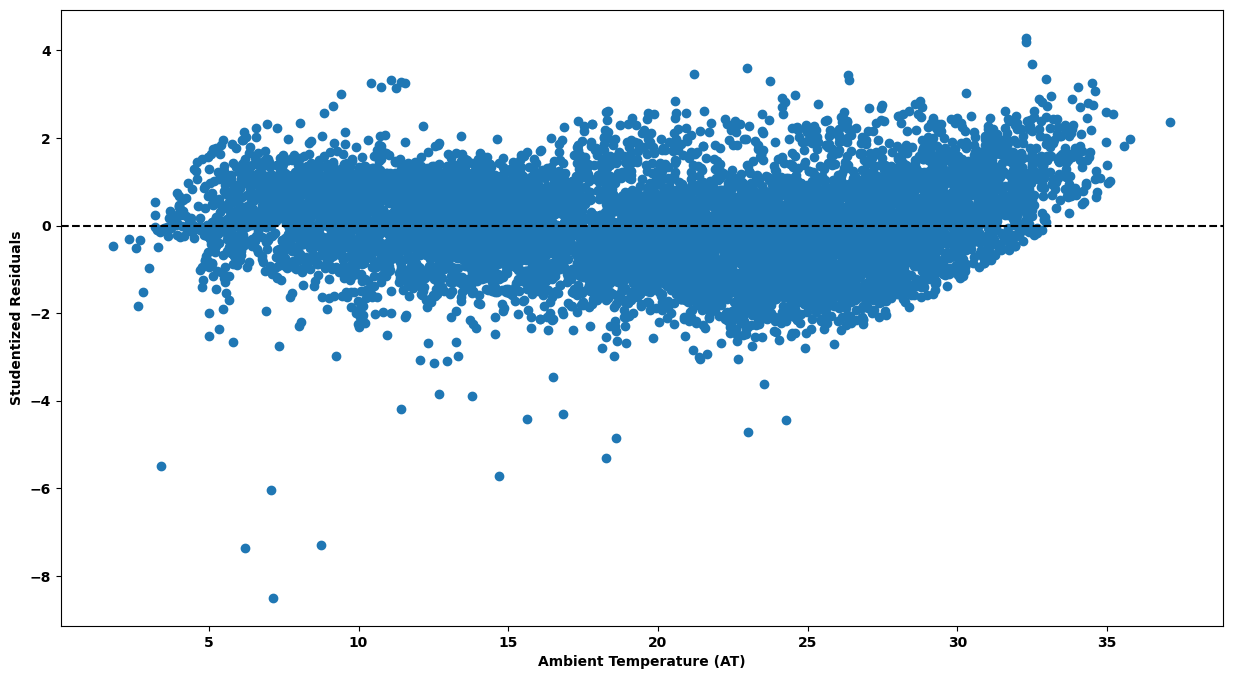

In [10]:
#display studentized residuals
stud_res = model_AT.outlier_test()
x = ccpp_df['Ambient Temperature (AT)']
y_arr = np.array(stud_res)
y = y_arr[...,0:1]

#create scatterplot of predictor variable vs. studentized residuals
plt.close()
plt.figure(figsize=(15,8))
plt.scatter(x, y)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Ambient Temperature (AT)')
plt.ylabel('Studentized Residuals')
plt.show()

The studentized residual is one which takes the error from the residual error, denoted by 'e-hat' and divides that by the estimate of its standard deviation. We typically expect absolute value of studentized residuals values >= 3 to be deemed an outlier. In this case, it would seem as if hardly any outliers are presented in the values for doing a simple linear regression between EP and AT. There's a handful of outliers here, like the ones that have residuals of magnitude >4, which ideally removing them might help in giving an even better fit for the regression - these points lie mainly at the lower range of AT. Given that these points seem to be too few/outliers, they might be the result of measurement error and re-examining them further might prove beneficial to the model.

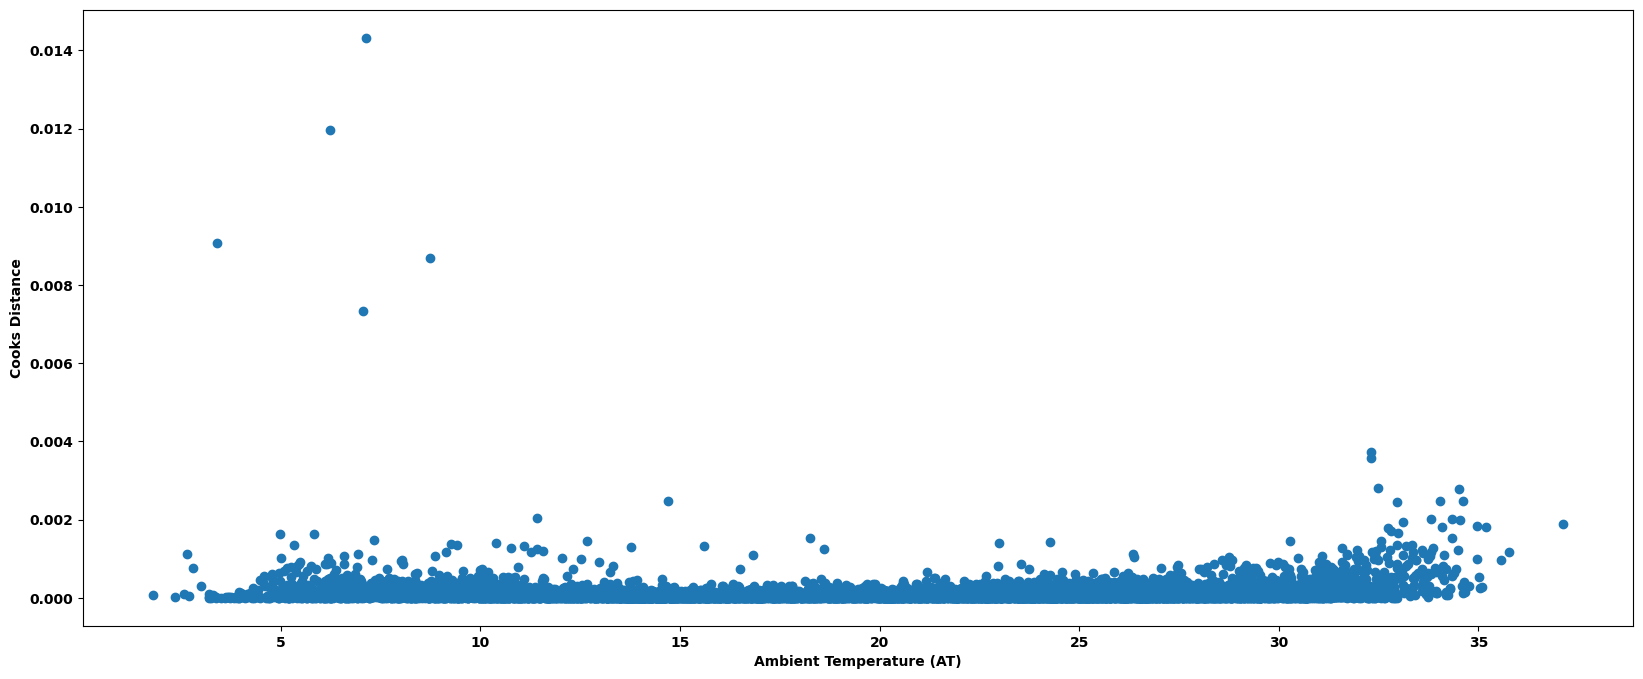

In [11]:
# finding Cook's distance
# create instance of influence
influence = model_AT.get_influence()
# obtain Cook's distance for each observation
cooks = influence.cooks_distance 

plt.close()
plt.figure(figsize=(20,8))
plt.scatter(ccpp_df['Ambient Temperature (AT)'].tolist(), cooks[0])
plt.xlabel('Ambient Temperature (AT)')
plt.ylabel('Cook''s Distance')
plt.show()

Cook's distance also seems to corroborate the idea of outliers based on the studentized residual analysis in the lower end of AT. For Cook's distance, one interpretation is to investigate any point over 4/n, where n is the number of observations (https://www.statisticshowto.com/cooks-distance/). Based on this metric, the we should re-examine points with a Cook's distance above 4/9568 = 0.00041806. From the y-axes of the diagram, it would seem that a lot of points are worth re-examining, apart from obvious outliers.

**_EP against V_**

In [12]:
Y = ccpp_df['Energy Output (EP)'].tolist()
X = ccpp_df['Exhaust Vacuum (V)'].tolist()
X = sm.add_constant(X)
model_V = sm.OLS(endog=Y,exog=X).fit()

print(model_V.summary(xname=['const','Exhaust Vacuum (V)']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:07:37   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                517.8015      0

eval_env: 1


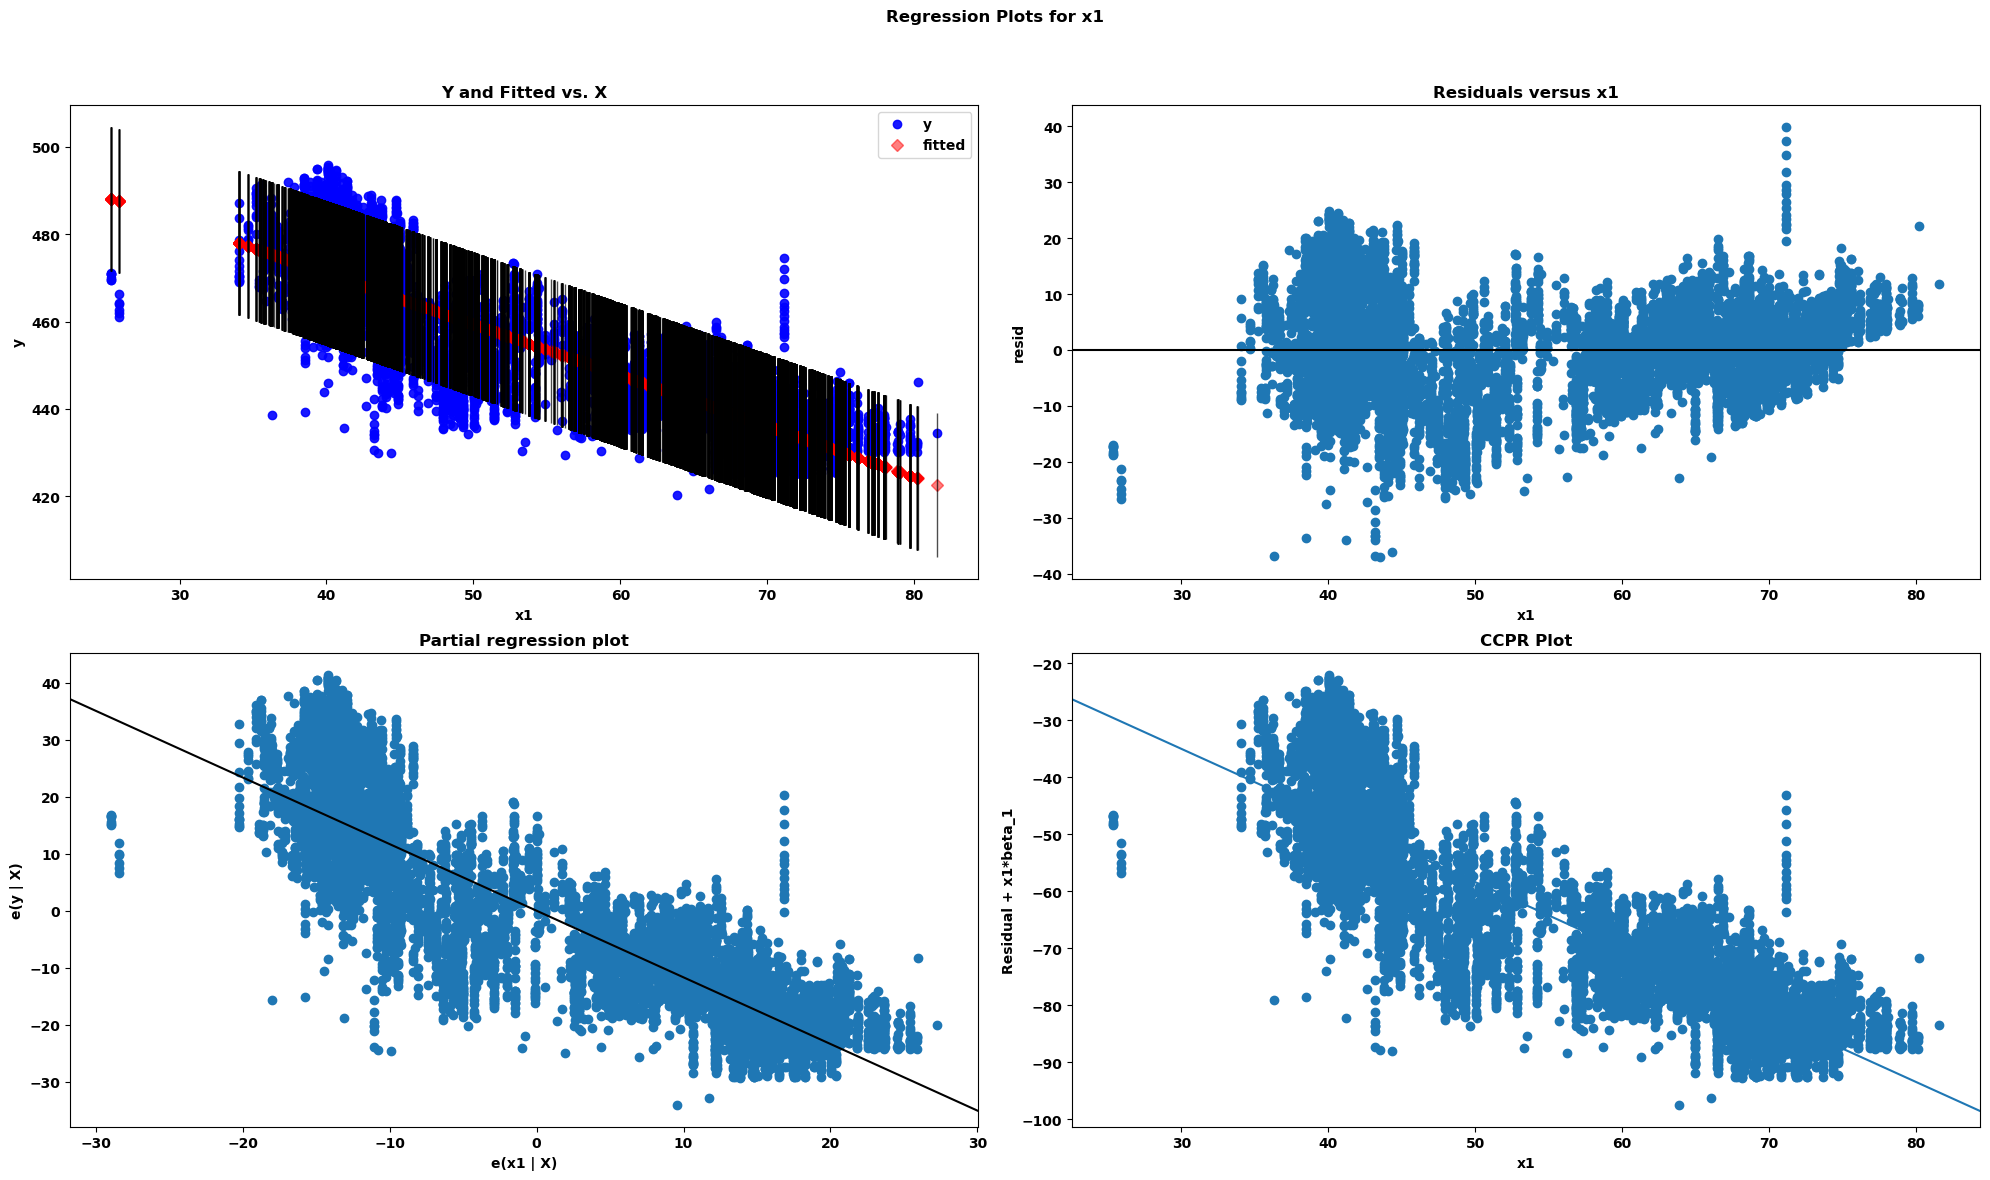

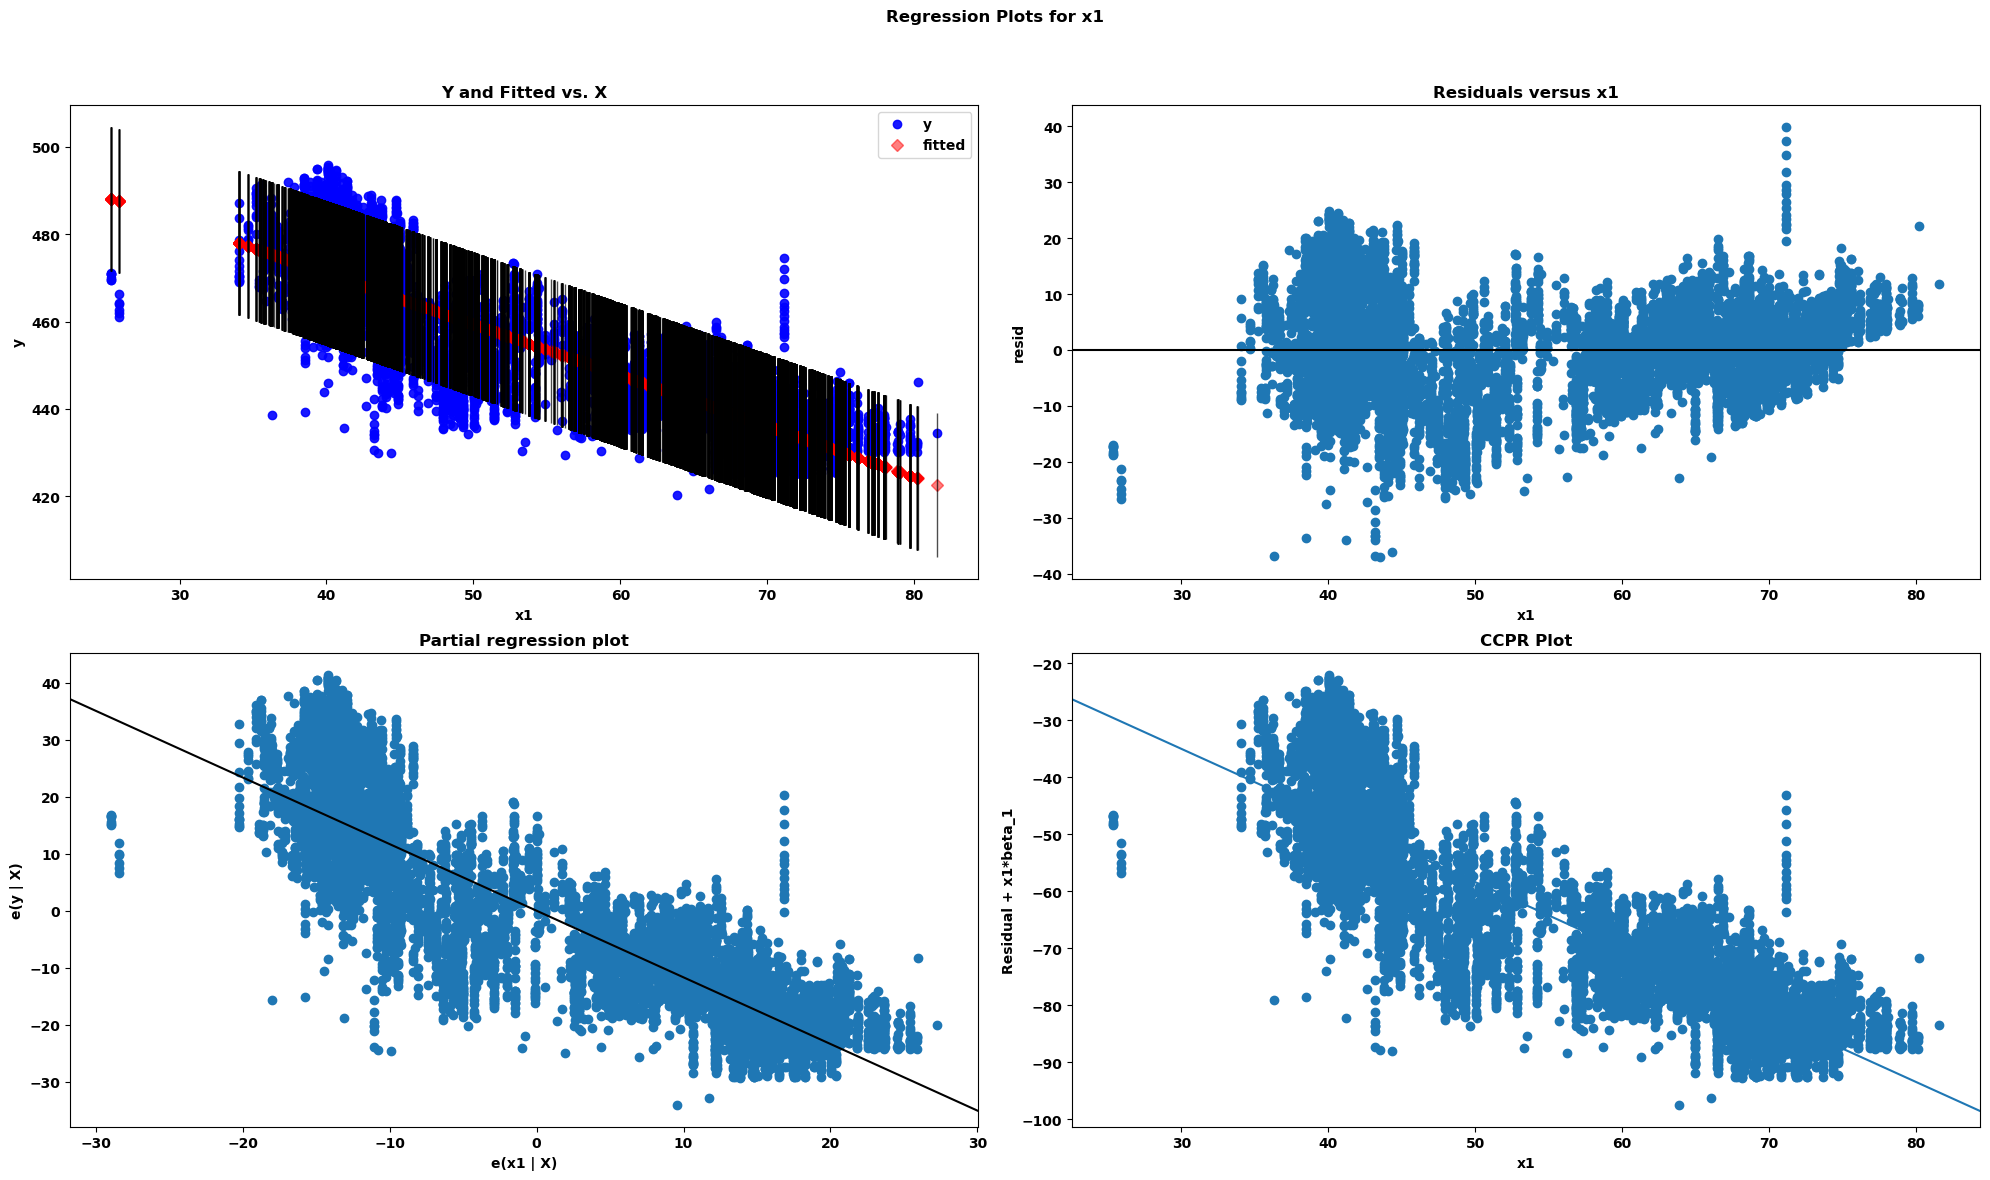

In [13]:
plt.close()
fig = plt.figure(figsize=(20,12))

#produce regression plots
sm.graphics.plot_regress_exog(model_V, 'x1', fig=fig)

The p-values observed are extremely small, |t-stats| >>> 2, therefore at the alpha=5%, (1-alpha)% confidence level we reject the null hypothesis and conclude that Exhaust Vacuum (V) has a statistically significant effect on Energy Output (EP). 
Note the R^2 value is 0.757, which means 75.7% of the variability could be explained by a simple fit against V.

Our residual analysis (note the diagram labelled residual vs x1 (where x1 = V)), shows that the residuals are fairly evenly distributed across the range of Vs, suggesting that our linear regression has successfully captured a good portion of the trends, which is what we expected to begin with from the pairsplots earlier.

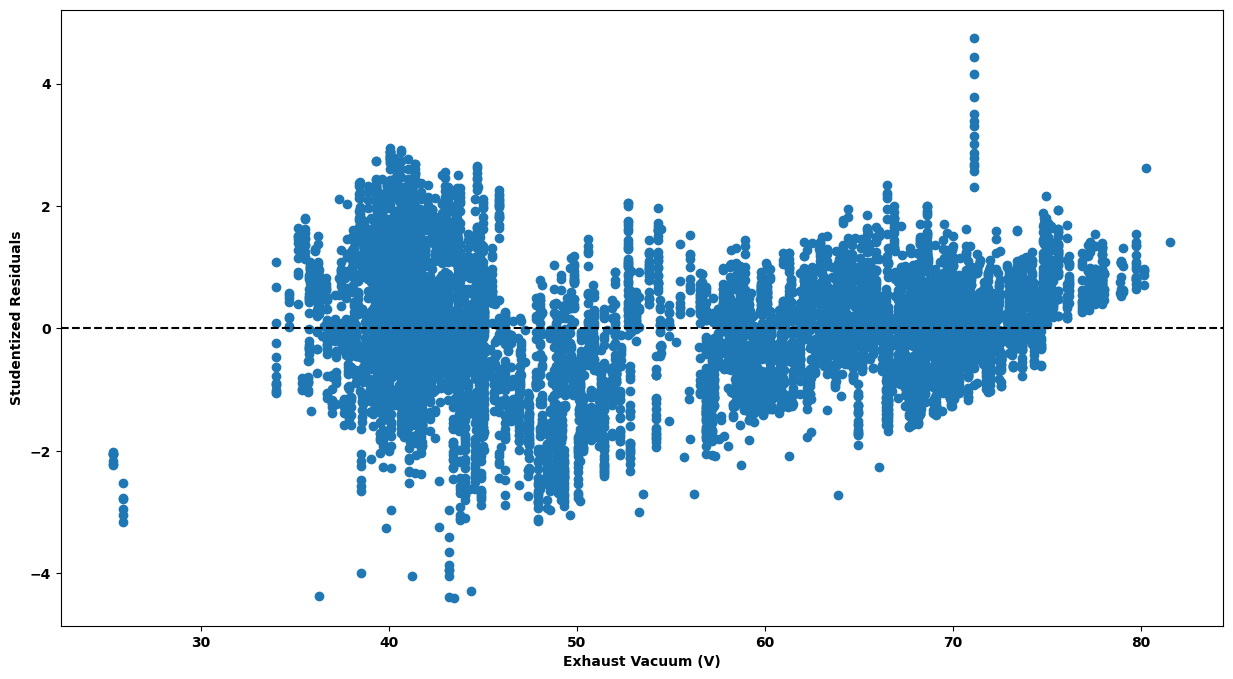

In [14]:
#display studentized residuals
stud_res = model_V.outlier_test()
x = ccpp_df['Exhaust Vacuum (V)']
y_arr = np.array(stud_res)
y = y_arr[...,0:1]

#create scatterplot of predictor variable vs. studentized residuals
plt.close()
plt.figure(figsize=(15,8))
plt.scatter(x, y)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Exhaust Vacuum (V)')
plt.ylabel('Studentized Residuals')
plt.show()

It would seem as if more outliers are presented in the values for doing a simple linear regression between EP and V as compared to EP and AT, but unlike the latter case no outlier is 8 magnitudes away - we should expect the Cook's distance to reflect this too with smaller outliers.

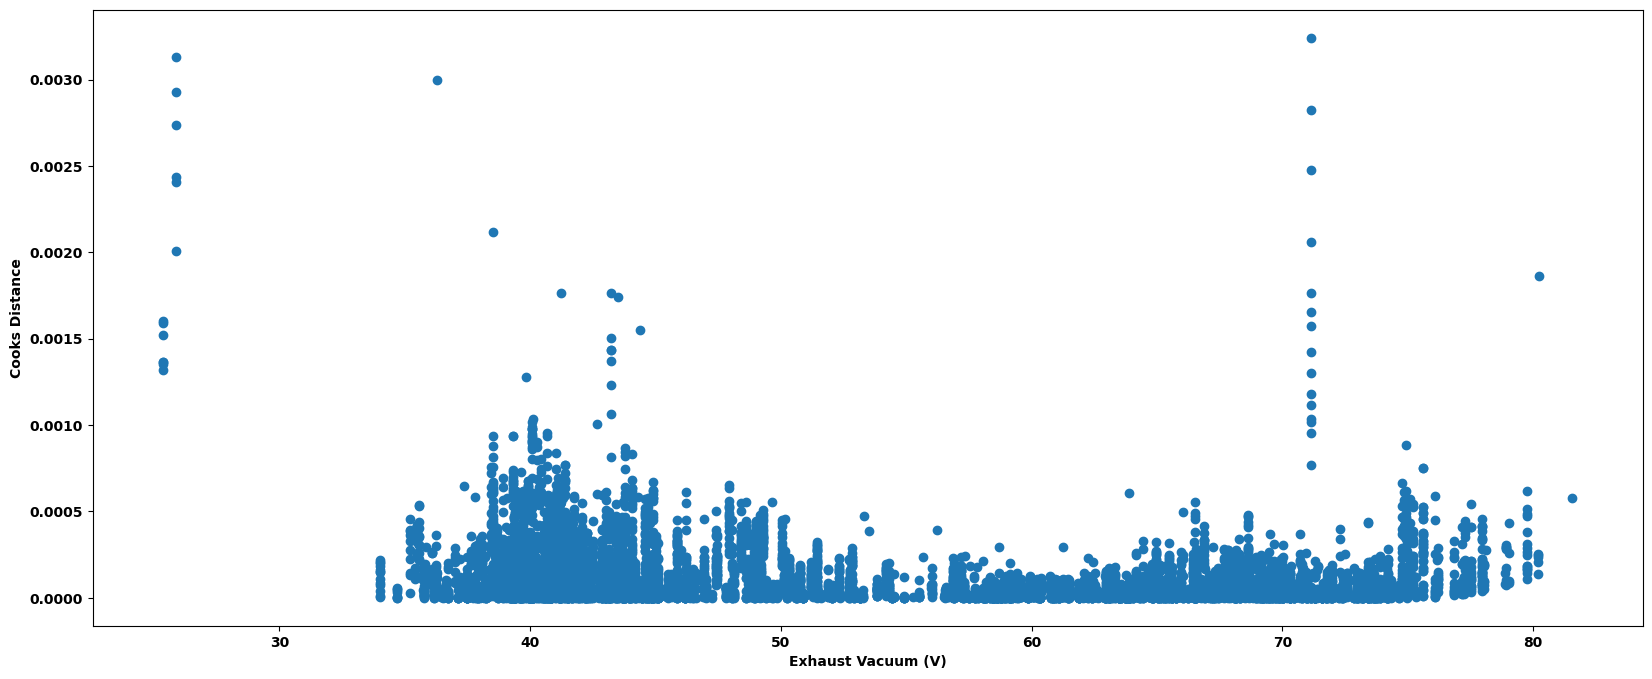

In [44]:
# finding Cook's distance
# create instance of influence
influence = model_V.get_influence()
# obtain Cook's distance for each observation
cooks = influence.cooks_distance 

plt.close()
plt.figure(figsize=(20,8))
plt.scatter(ccpp_df['Exhaust Vacuum (V)'].tolist(), cooks[0])
plt.xlabel('Exhaust Vacuum (V)')
plt.ylabel('Cook''s Distance')
plt.show()

For Cook's distance, one interpretation is to investigate any point over 4/n, where n is the number of observations (https://www.statisticshowto.com/cooks-distance/). Based on this metric, the we should re-examine points with a Cook's distance above 4/9568 = 0.00041806. From the y-axes of the diagram, it would seem that many points are worth re-examining, apart from obvious outliers. Comparing the y-axis of Cook's distance for AT and V, we see that outliers in V in general are far closer than in the case of AT.

**_EP against AP_**

In [16]:
Y = ccpp_df['Energy Output (EP)'].tolist()
X = ccpp_df['Ambient Pressure (AP)'].tolist()
X = sm.add_constant(X)
model_AP = sm.OLS(endog=Y,exog=X).fit()

print(model_AP.summary(xname=['const','Ambient Pressure (AP)']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:07:54   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1055.26

eval_env: 1


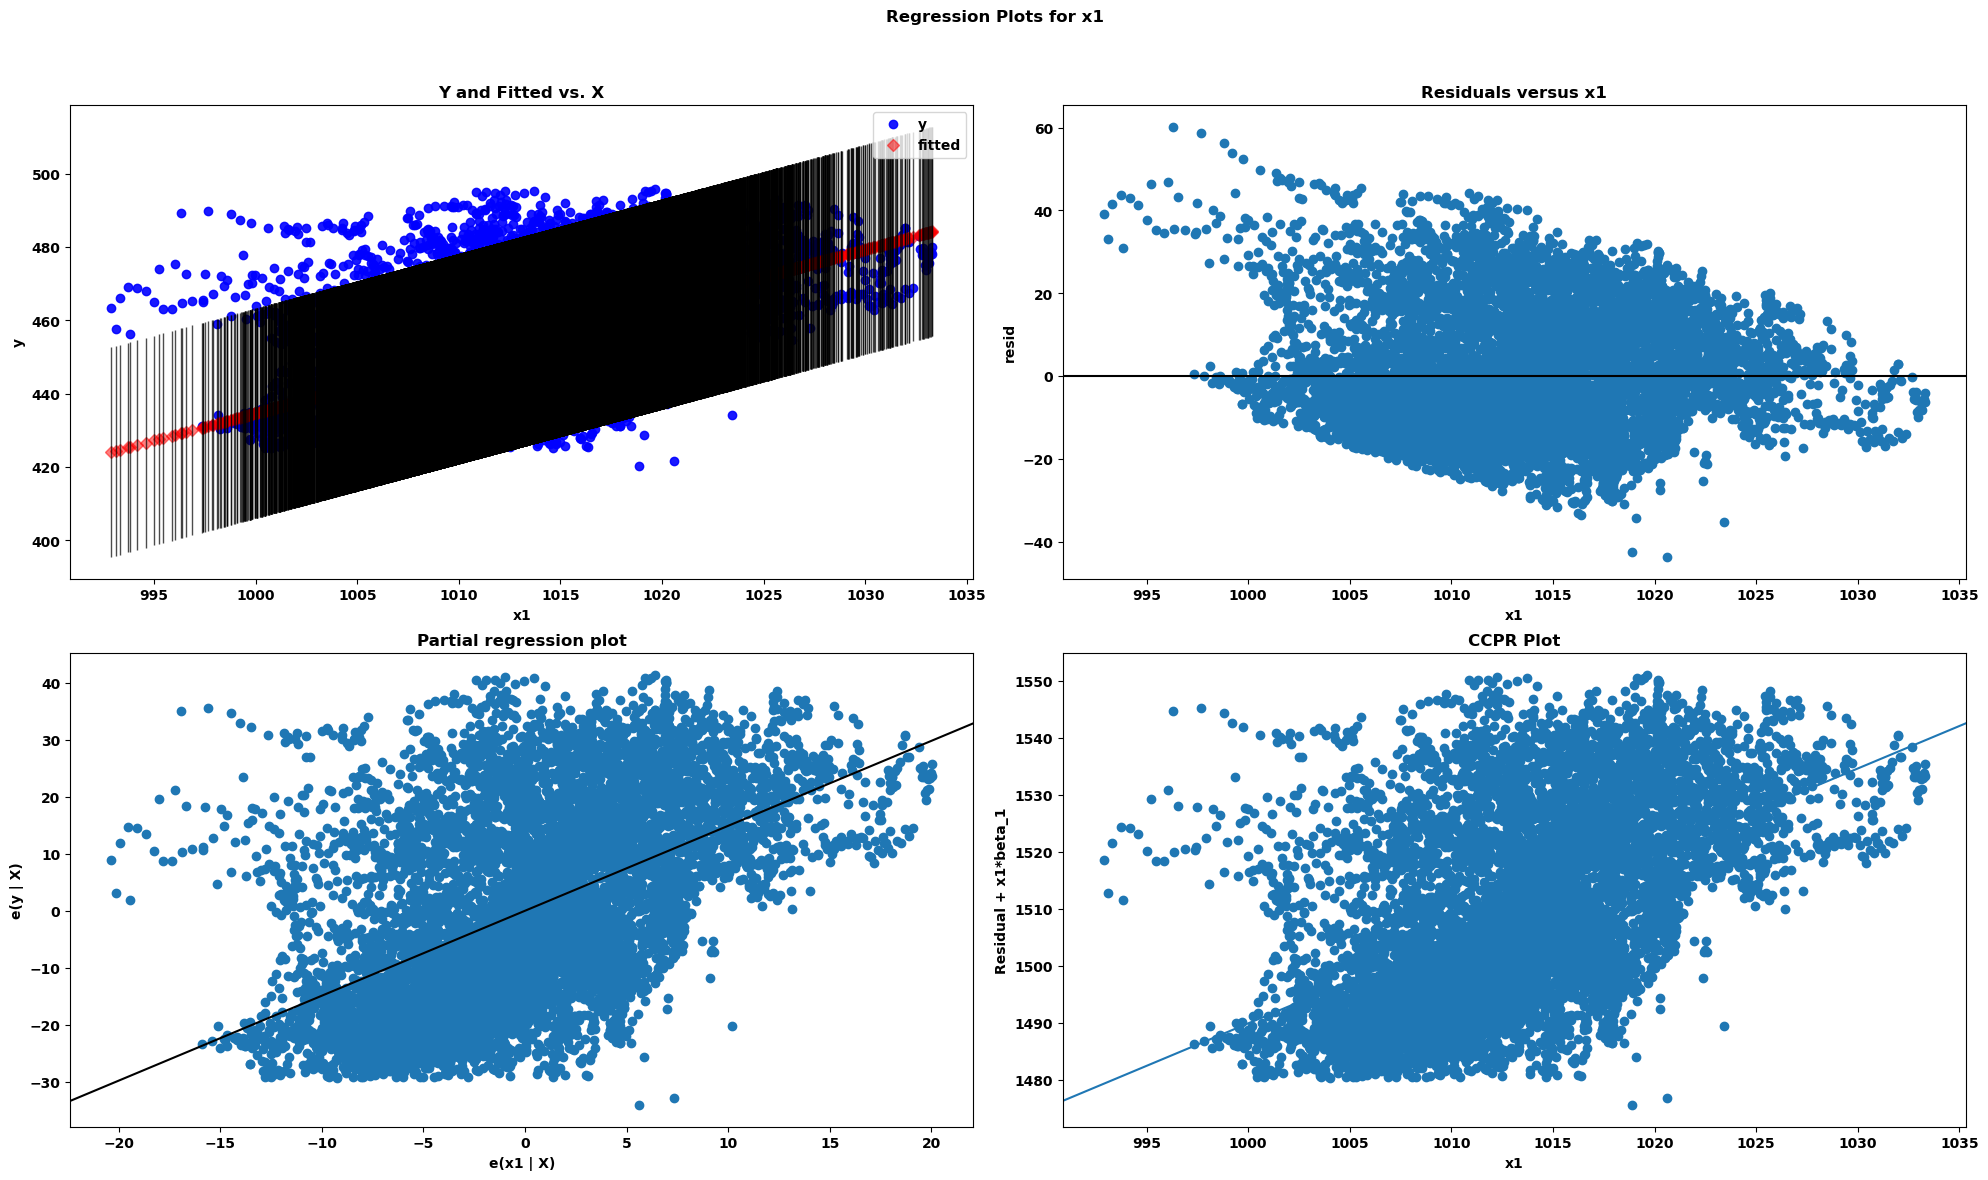

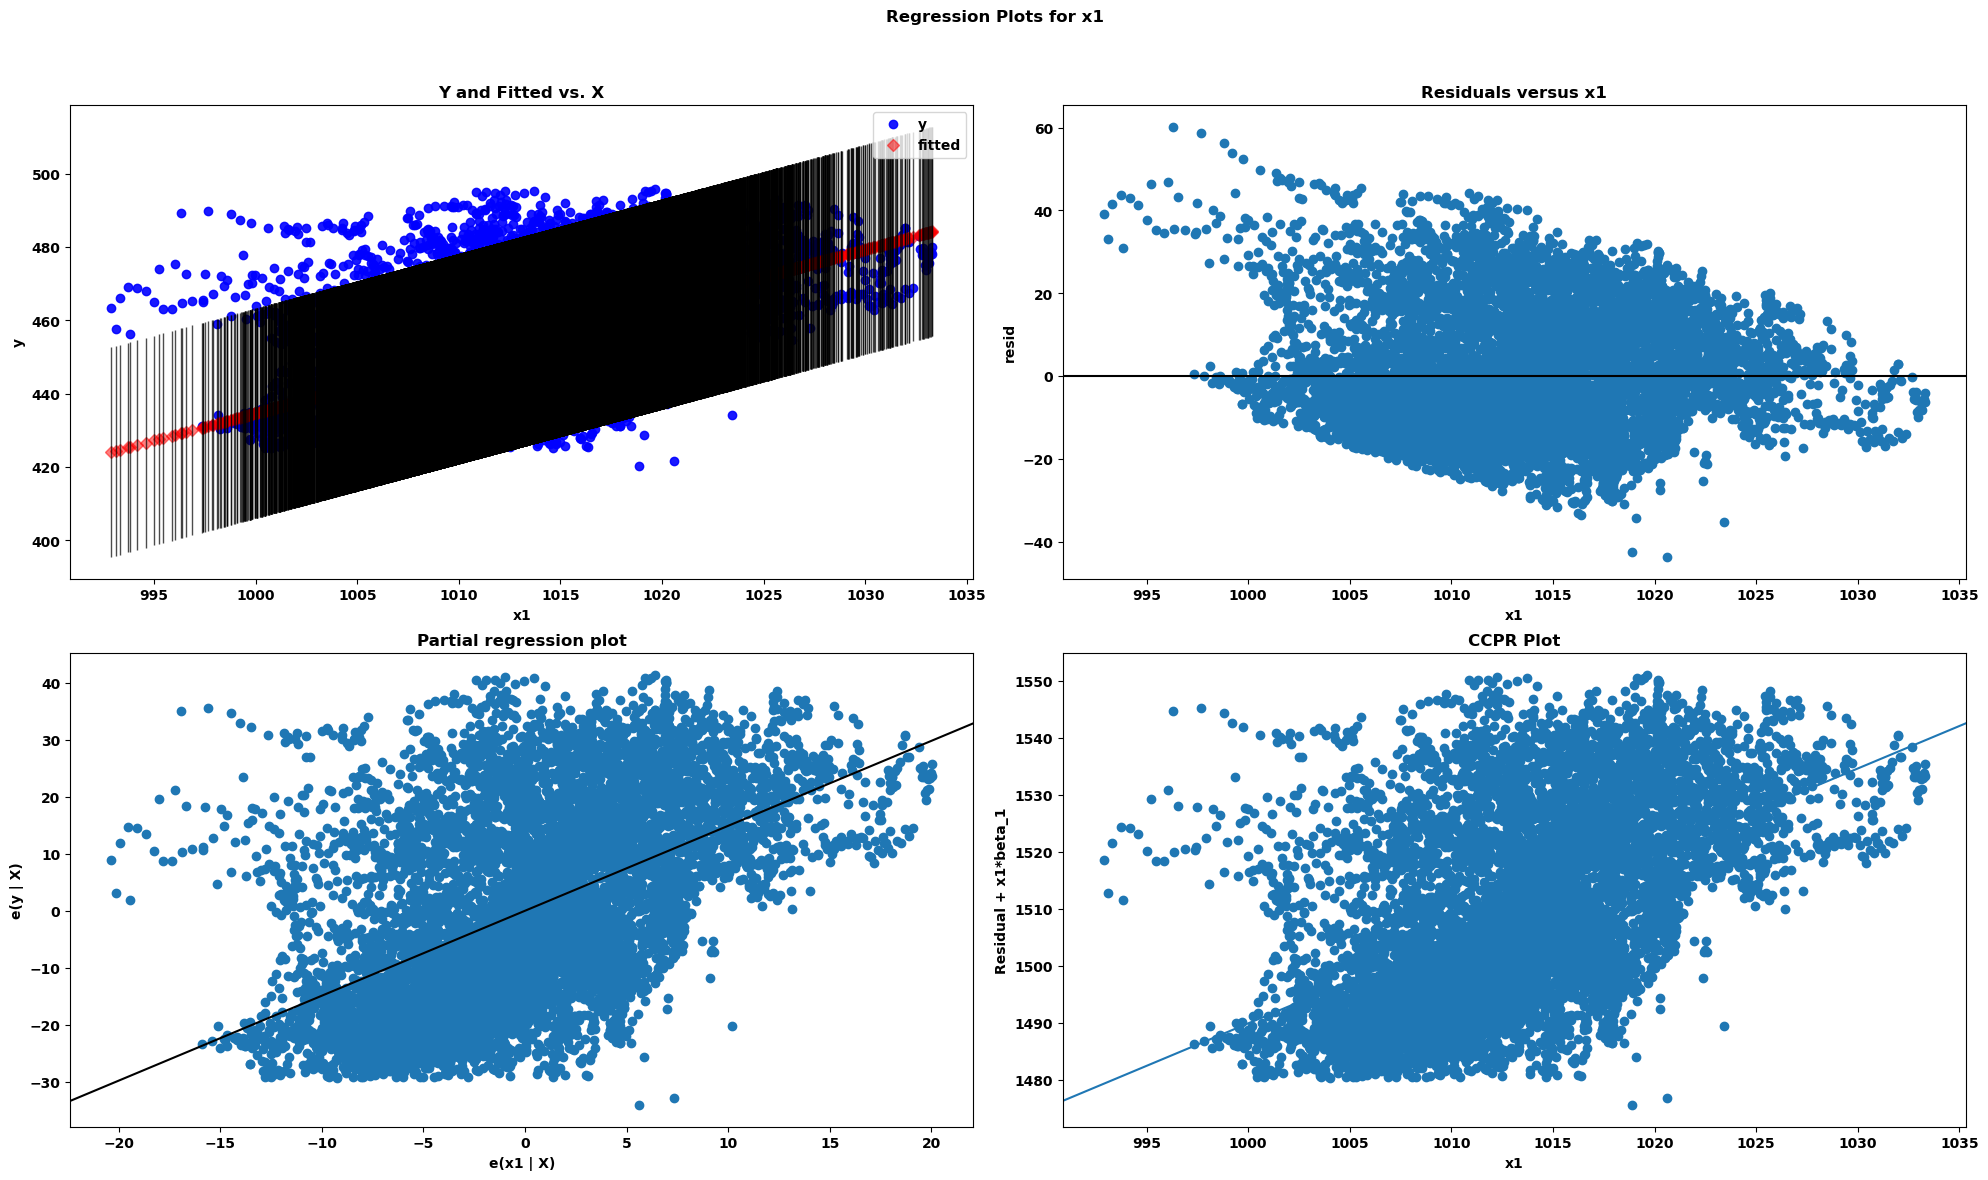

In [17]:
plt.close()
fig = plt.figure(figsize=(20,12))

#produce regression plots
sm.graphics.plot_regress_exog(model_AP, 'x1', fig=fig)

The p-values observed are extremely small, |t-stats| >>> 2, therefore at the alpha=5%, (1-alpha)% confidence level we reject the null hypothesis and conclude that Ambient Pressure (AP) has a statistically significant effect on Energy Output (EP). 
Note the R^2 value is 0.269, which means 26.9% of the variability could be explained by a simple fit against AP.

Our residual analysis (note the diagram labelled residual vs x1 (where x1 = AP)), which shows that the residuals are widespread but have a downwards sloping trend overall for AP, suggesting that our linear regression has not successfully explained/captured the trends data for AP, since a clear trend is still visible in the residual error.

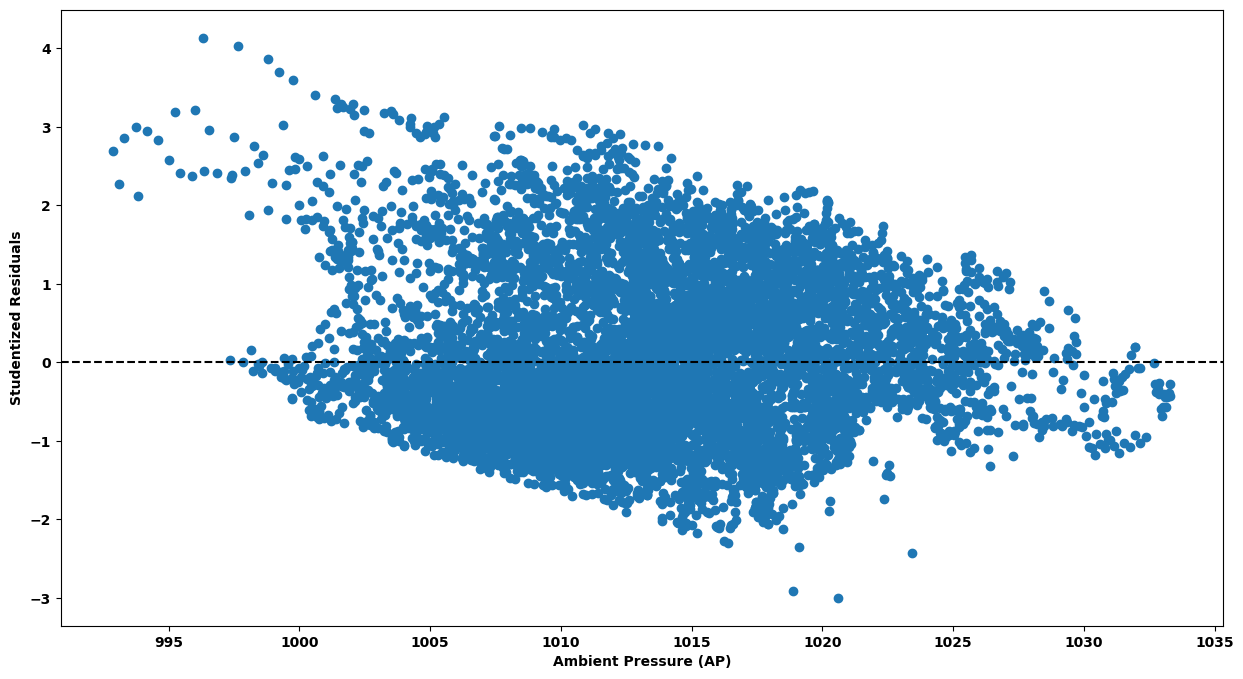

In [18]:
#display studentized residuals
stud_res = model_AP.outlier_test()
x = ccpp_df['Ambient Pressure (AP)']
y_arr = np.array(stud_res)
y = y_arr[...,0:1]

#create scatterplot of predictor variable vs. studentized residuals
plt.close()
plt.figure(figsize=(15,8))
plt.scatter(x, y)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Ambient Pressure (AP)')
plt.ylabel('Studentized Residuals')
plt.show()

In this case, it would seem as if hardly any outliers are presented in the values for doing a simple linear regression between EP and AP. There's a handful of outliers here, like the ones that have residuals of magnitude >4, which ideally removing them might help in giving an even better fit for the regression - these points lie mainly at the lower range of AP.

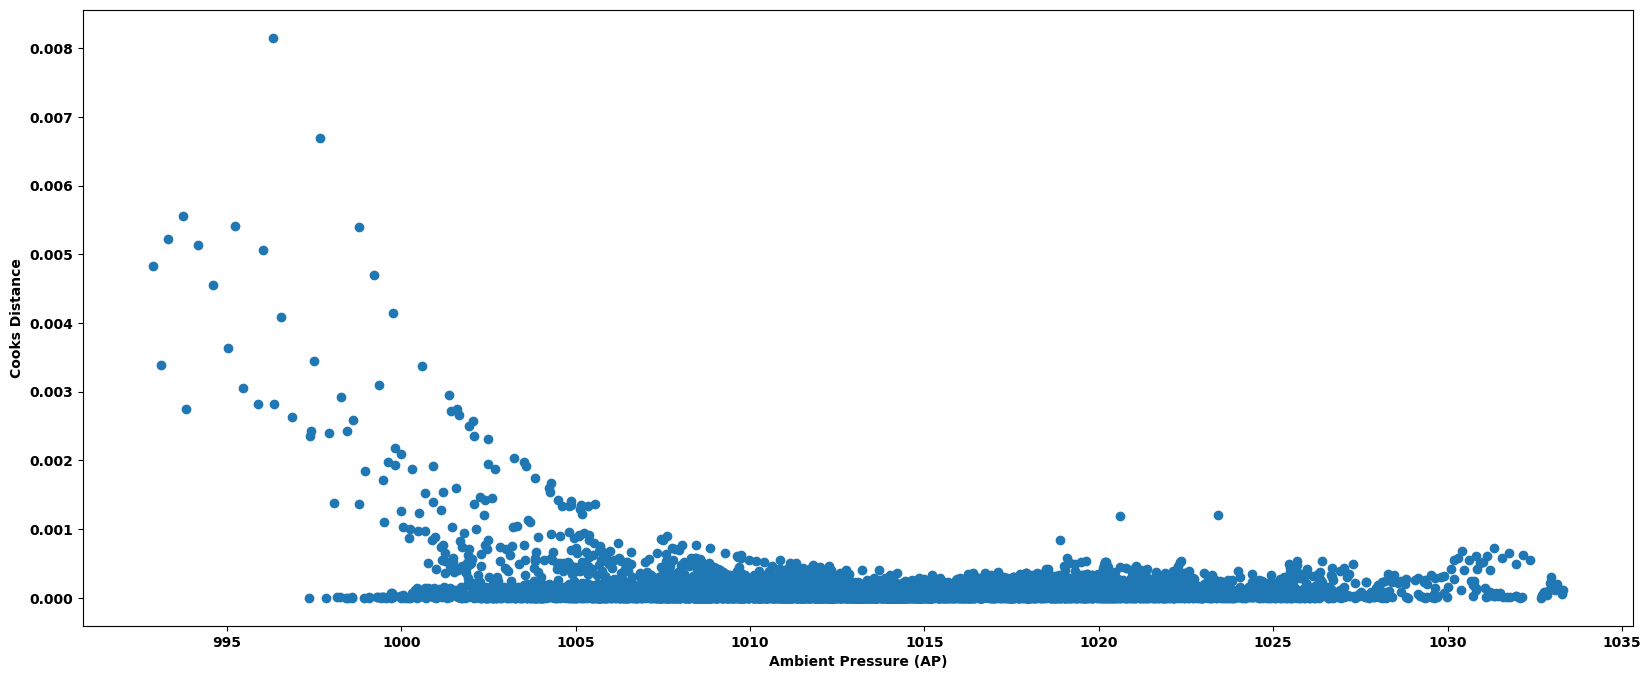

In [19]:
# finding Cook's distance
# create instance of influence
influence = model_AP.get_influence()
# obtain Cook's distance for each observation
cooks = influence.cooks_distance 

plt.close()
plt.figure(figsize=(20,8))
plt.scatter(ccpp_df['Ambient Pressure (AP)'].tolist(), cooks[0])
plt.xlabel('Ambient Pressure (AP)')
plt.ylabel('Cook''s Distance')
plt.show()

For Cook's distance, one interpretation is to investigate any point over 4/n, where n is the number of observations (https://www.statisticshowto.com/cooks-distance/). Based on this metric, the we should re-examine points with a Cook's distance above 4/9568 = 0.00041806. From the y-axes of the diagram, it would seem that a lot of points are worth re-examining, apart from obvious outliers which we observe mostly in the lower range of AP. Given how a trend clear was still visible in the residual plots, this might merit further investigation on whether EP is linearly related to AP or not.

**_EP against RH_**

In [20]:
Y = ccpp_df['Energy Output (EP)'].tolist()
X = ccpp_df['Relative Humidity (RH)'].tolist()
X = sm.add_constant(X)
model_RH = sm.OLS(endog=Y,exog=X).fit()

print(model_RH.summary(xname=['const','Relative Humidity (RH)']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:09   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    420

eval_env: 1


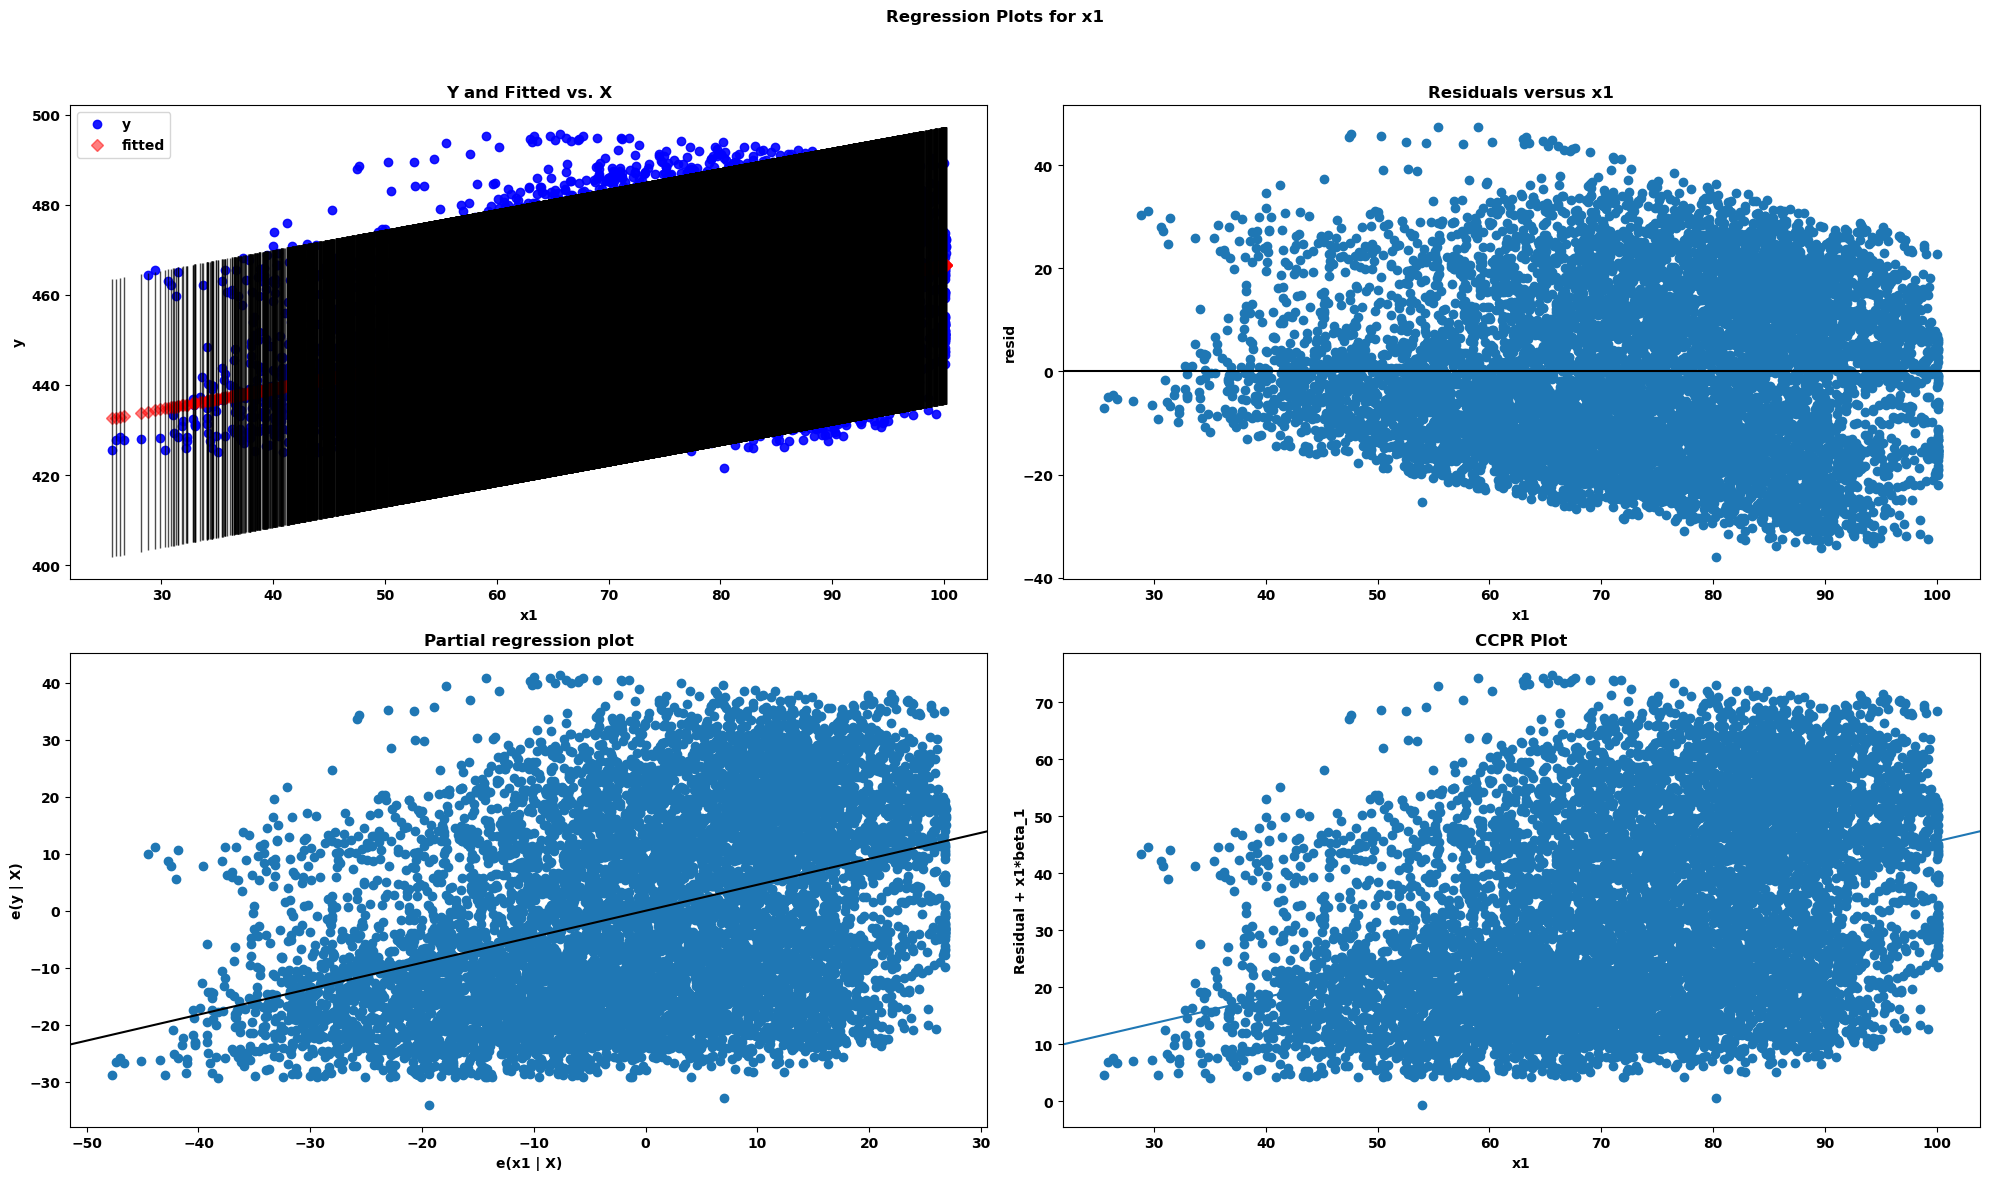

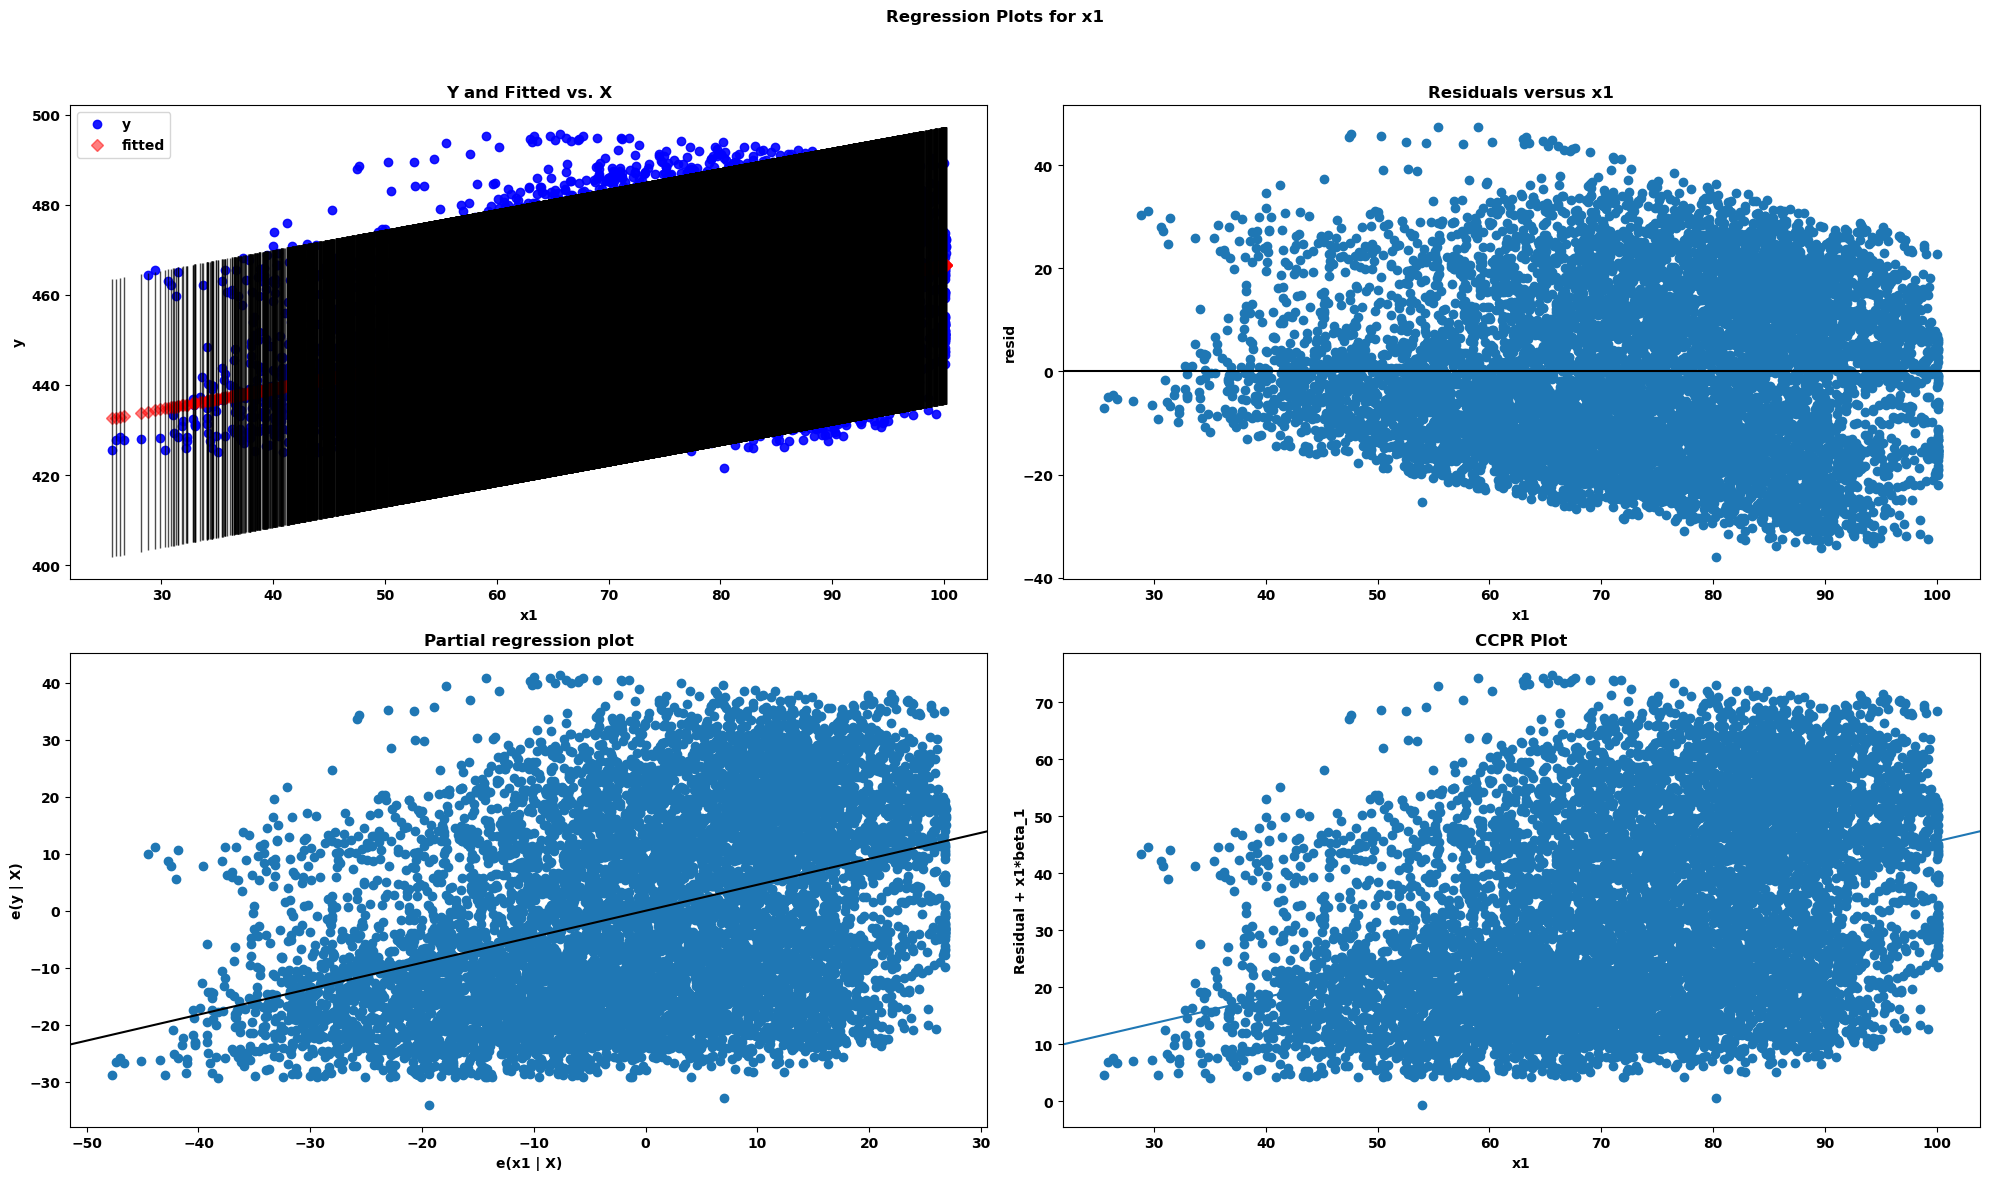

In [21]:
plt.close()
fig = plt.figure(figsize=(20,12))

#produce regression plots
sm.graphics.plot_regress_exog(model_RH, 'x1', fig=fig)

The p-values observed are extremely small, |t-stats| >>> 2, therefore at the alpha=5%, (1-alpha)% confidence level we reject the null hypothesis and conclude that Relative Humidity (RH) has a statistically significant effect on Energy Output (EP). 
Note the R^2 value is 0.152, which means 15.2% of the variability could be explained by a simple fit against Rh, the lowest of the four variables.

Our residual analysis (note the diagram labelled residual vs x1 (where x1 = RH)), which shows that the residuals are widespread but have a downwards sloping trend overall for RH, suggesting that our linear regression has not successfully explained/captured the trends data for RH, since a clear trend is still visible in the residual error.

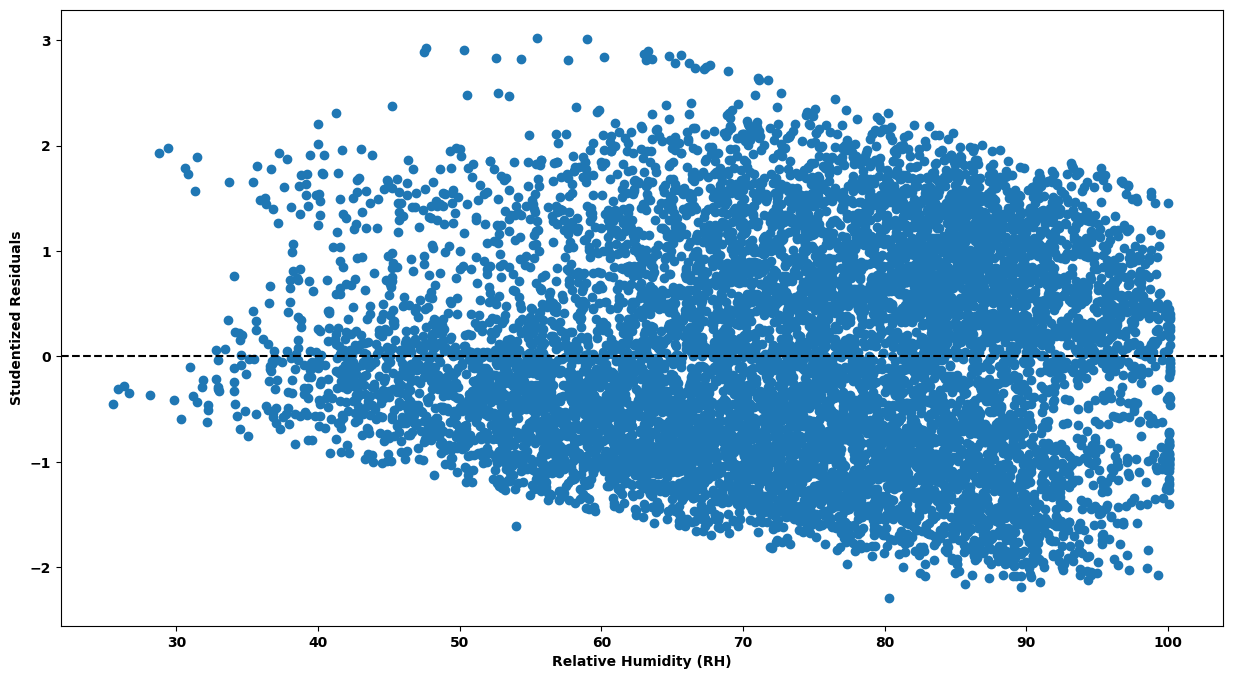

In [22]:
#display studentized residuals
stud_res = model_RH.outlier_test()
x = ccpp_df['Relative Humidity (RH)']
y_arr = np.array(stud_res)
y = y_arr[...,0:1]

#create scatterplot of predictor variable vs. studentized residuals
plt.close()
plt.figure(figsize=(15,8))
plt.scatter(x, y)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('Studentized Residuals')
plt.show()

In this case, it would seem as if hardly any outliers are presented in the values for doing a simple linear regression between EP and RH.

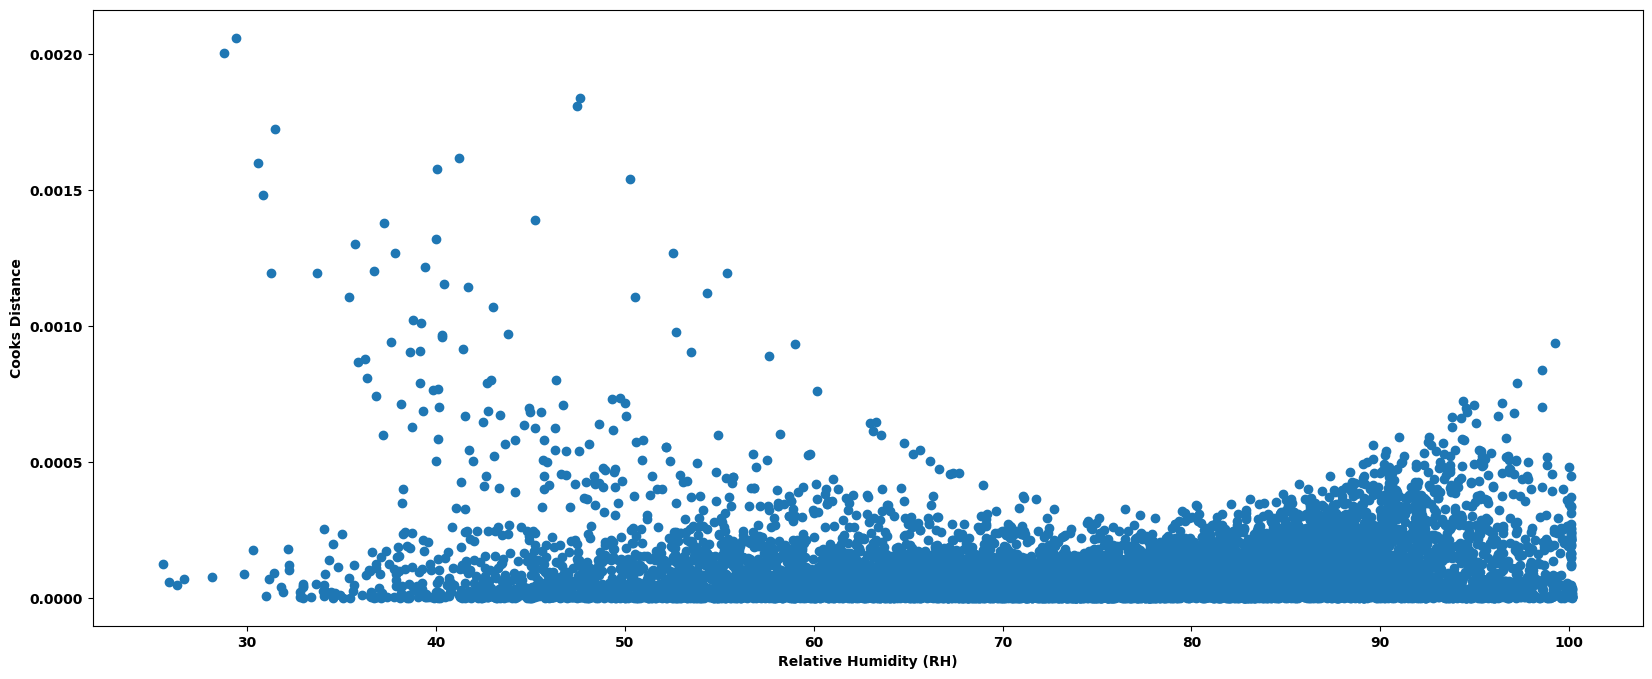

In [23]:
# finding Cook's distance
# create instance of influence
influence = model_RH.get_influence()
# obtain Cook's distance for each observation
cooks = influence.cooks_distance 

plt.close()
plt.figure(figsize=(20,8))
plt.scatter(ccpp_df['Relative Humidity (RH)'].tolist(), cooks[0])
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('Cook''s Distance')
plt.show()

For Cook's distance, one interpretation is to investigate any point over 4/n, where n is the number of observations (https://www.statisticshowto.com/cooks-distance/). Based on this metric, the we should re-examine points with a Cook's distance above 4/9568 = 0.00041806. From the y-axes of the diagram, it would seem that RH has the least points worth re-examining compared to the simple linear regressions done between EP and the four independent features. Given how a trend clear was still visible in the residual plots, this might merit further investigation on whether EP is linearly related to RH or not.

**(d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?**

In [24]:
Y = ccpp_df['Energy Output (EP)']
X = ccpp_df.iloc[...,:4]
X = sm.add_constant(X)
model_multi = sm.OLS(Y,X).fit()

print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:     Energy Output (EP)   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:24   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The p value for all the feature variables (AT, V, AP, RH) is extremely small (0.000). As p-value are extremely small and |t-stat| > 2, at alpha=5%, (1-alpha)% confidence level all the predictors are statistically significant, and therefore we can reject the null hypothesis that  H0 : βj = 0 for all four predictors. 

Note that the R^2 value is 0.929, which means that 92.9% of the variability of the model can be explained by the four variables, implying that the linear regression model might be a good fit. Given that we already know a simple linear regression of EP against AT has a R^2 value of 0.899 which is already very close to the R^2 value here, it would appear that multicollinearity might be an issue in this situation and needs to be examined further. This is also brought up by the results summary under warning [2].

**(e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is
displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.**

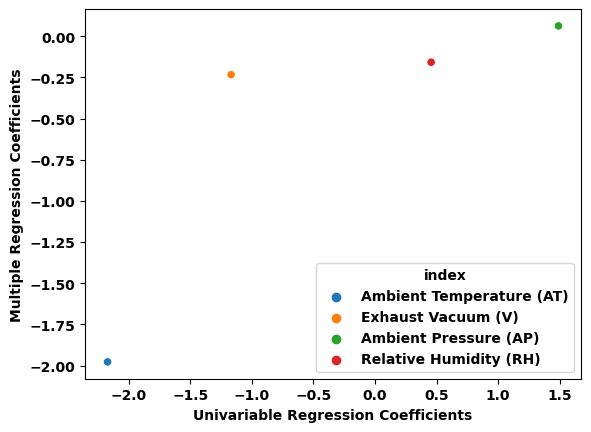

In [25]:
results_1c = np.array([model_AT.params, model_V.params, model_AP.params, model_RH.params])
#removing coefficients' column
x_axis = results_1c[...,1:].flatten()

results_1d = np.array([model_multi.params]).flatten()
y_axis = np.delete(results_1d, 0)

feature_names  = ['Ambient Temperature (AT)', 'Exhaust Vacuum (V)', 'Ambient Pressure (AP)', 'Relative Humidity (RH)']

data_dict = {}
for i in range(len(feature_names)):
    data_dict[feature_names[i]] = (x_axis[i],y_axis[i])
data_df = pd.DataFrame(data_dict)
data_df = data_df.T
data_df = data_df.rename(columns={0: "Univariable Regression Coefficients", 1: "Multiple Regression Coefficients"})
data_df = data_df.reset_index()

sns.scatterplot(data=data_df, x="Univariable Regression Coefficients", y="Multiple Regression Coefficients", hue='index')
plt.show()

It appears that only the AT variable has a coefficient that is similar in size in both cases (around -2 for both). V was around -1 in 1c, around -0.25 in 1d. RH was around 0.5 in 1c, around -0.125 in 1d. AP was around 1.5 in 1c, around 0.1 in 1d. This suggests that of the four variables, Ambient Temperature (AT) might have the most predictive power in order to determine Energy Output (EP) accurately.

**(f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form*:**
<h1><center> Y = β0 + β1X + β2X^2 + β3X^3 + ε </center></h1>

*https://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features

**_EP against AT (nonlinear association/polynomial fit linear regression)_**

In [26]:
Y = ccpp_df['Energy Output (EP)'].tolist()
X = np.array(ccpp_df['Ambient Temperature (AT)']).reshape(-1, 1)

poly = PolynomialFeatures(3)
X = poly.fit_transform(X)

poly_model_AT = sm.OLS(Y,X).fit()

print(poly_model_AT.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:25   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

All the p-values observed are small, with |t-stat| > 2, so at alpha=5%, (1-alpha)% significance level we reject all the null hypotheses, infer that the predictors are statistically significant and see that a non-linear fit for EP against AT improves the model (adjusted R^2 of 0.899 before in 1c vs. 0.912 now). Note how β3 is extremely small, implying that there is a significant fit upto the second-order polynomial to account for the accuracy of EP against AT, and the third-order polynomial has a small impact in explaining the variability within the model.

**_EP against V (nonlinear association/polynomial fit linear regression)_**

In [27]:
Y = ccpp_df['Energy Output (EP)'].tolist()
X = np.array(ccpp_df['Exhaust Vacuum (V)']).reshape(-1, 1)

poly = PolynomialFeatures(3)
X = poly.fit_transform(X)

poly_model_V = sm.OLS(Y,X).fit()

print(poly_model_V.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:25   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.0

All except the p-values for x2 (x^2) observed are small, with |t-stat| > 2. For x2, we fail to reject the null hypothesis that β2=0, and the coefficient for x2 is not statistically significant. At alpha=5%, (1-alpha)% significance level, we can reject the remaining null hypotheses, infer the remaining predictors are statistically significant and see that a non-linear fit for EP against V improves the model (adjusted R^2 of 0.756 before in 1c vs. 0.775 now). Note how β3 is again extremely small, implying that there is a significant fit upto the first-order polynomial to account for the accuracy of EP against V, and the third-order polynomial has a small impact in explaining the variability within the model.

**_EP against AP (nonlinear association/polynomial fit linear regression)_**

In [28]:
Y = ccpp_df['Energy Output (EP)'].tolist()
X = np.array(ccpp_df['Ambient Pressure (AP)']).reshape(-1, 1)

poly = PolynomialFeatures(3)
X = poly.fit_transform(X)

poly_model_AP = sm.OLS(Y,X).fit()

print(poly_model_AP.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:25   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.0

All the p-values observed are small, with |t-stat| > 2, so at alpha=5%, (1-alpha)% significance level we reject all the null hypotheses, infer that the predictors are statistically significant and see that a non-linear fit for EP against AP improves the model (adjusted R^2 of 0.269 before in 1c vs. 0.275 now). Note how β2 is relatively small and β3 is extremely small, implying that there is the second-order third-order polynomial has a small impact in explaining the variability within the model. Also, the new R^2 value is still small when compared to first-order/polynomial-fit models of EP against AT/V, which suggests that linear regression might not be an effective tool in utilizing this input (AP) for accurately predicting output (EP).

**_EP against RH (nonlinear association/polynomial fit linear regression)_**

In [29]:
Y = ccpp_df['Energy Output (EP)'].tolist()
X = np.array(ccpp_df['Relative Humidity (RH)']).reshape(-1, 1)

poly = PolynomialFeatures(3)
X = poly.fit_transform(X)

poly_model_RH = sm.OLS(Y,X).fit()

print(poly_model_RH.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:25   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.0

All the p-values observed are small, with |t-stat| > 2, so at alpha=5%, (1-alpha)% significance level we reject all the null hypotheses, infer that the predictors are statistically significant and see that a non-linear fit for EP against RH improves the model (adjusted R^2 of 0.152 before in 1c vs. 0.153 now). Note how β2 is relatively small and β3 is extremely small, implying that there is the second-order third-order polynomial has a small impact in explaining the variability within the model. Also, the new R^2 value is still small when compared to first-order/polynomial-fit models of EP against AT/V  and the increase with the polynomial fit is only 0.001, which suggests that linear regression might not be an effective tool in utilizing this input (RH) for accurately predicting output (EP).

**(g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.**

In [30]:
Y = ccpp_df['Energy Output (EP)']

X = ccpp_df[feature_names]
poly = PolynomialFeatures(interaction_only=True)
X_transformed = poly.fit_transform(X)
X_transformed_df = pd.DataFrame(data=X_transformed, columns=poly.get_feature_names_out())


model_interactions = sm.OLS(Y,sm.add_constant(X_transformed_df)).fit()

# feature_label = ['x0', 'x1', 'x2', 'x3']
# for i in range(4):
#     print(str(feature_label[i]),"=",feature_names[i])

model_interactions.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Energy Output (EP)   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:25   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
1                                                 685.7825     78.640      8.721      0.000     531.631     839.934
Ambient Temperature (AT)                           -4.3470      2.373     -1.832      0.067      -8.999       0.305
Exhaust Vacuum (V)                                 -7.6749      1.351     -5.682      0.000     -10.323      -5.027
Ambient Pressure (AP)                              -0.1524      0.077     -1.983      0.047      -0.303      -0.002
Relative Humidity (RH)                              1.5709      0.773      2.031      0.042       0.055       3.087
Ambient Temperature (AT) Exhaust Vacuum (V)         0.0210      0.001     23.338      0.000       0.019       0.023
Ambient Temperature (AT) Ambient Pressure (AP)      0.0018      0.002      0.752      0.452      -0.003       0.006
Ambient Temperature (AT) Relative Humidity (RH)    -0.0052      0.001     -6.444      0.000      -0.007      -0.004
Exhaust Vacuum (V) Ambient Pressure (AP)            0.0068      0.001      5.135      0.000       0.004       0.009
Exhaust Vacuum (V) Relative Humidity (RH)           0.0008      0.000      1.716      0.086      -0.000       0.002
Ambient Pressure (AP) Relative Humidity (RH)       -0.0016      0.001     -2.125      0.034      -0.003      -0.000
==============================================================================
Omnibus:                     1454.609   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9170.848
Skew:                          -0.574   Prob(JB):                         0.00
Kurtosis:                       7.657   Cond. No.                     1.70e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on the p-values, it would appear that apart from Ambient Temperature (AT), the interaction term between Ambient Temperature (AT) and Ambient Pressure (AP), and the interaction term between Exhaust Vacuum (V) and Relative Humidity (RH), the remaining terms are statistically signficant at the alpha=5%, (1-alpha)% significance level and we can reject the null hypothesis.  
  
Thus, we have to further examine AT, AT AP, and V RH. Because AT has many interaction terms with which are statistically significant so if we dropped AT we would lose all those statistically significant interaction terms, AT will not removed in a further analysis situation. However, the interaction variables AT AP and V RH could be potentially dropped due to their high p-values/low t-stats.  

**(h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.**

Resources consulted:
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
- https://atmamani.github.io/projects/ml/sklearn_statmodels_linear_regression/

In [31]:
#we set this first so that the future analysis will be against the same randomly seeded dataset
Y = ccpp_df['Energy Output (EP)']
X = ccpp_df[feature_names]
rand_state = random.randint(0, 2**32 - 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rand_state)

mse_results_dict = {}

In [32]:
X_train_vanilla = sm.add_constant(X_train)
X_test_vanilla = sm.add_constant(X_test)
Y_train_vanilla = Y_train
Y_test_vanilla = Y_test

#training regression model - vanilla version with all the predictors

model = sm.OLS(Y_train_vanilla,X_train_vanilla).fit()
print(model.summary())

#using training data and evaluating MSE
Y_train_pred_vanilla = model.predict(X_train_vanilla)
train_mse = metrics.mean_squared_error(Y_train_vanilla, Y_train_pred_vanilla)

#using testing data and evaluating MSE
Y_test_pred_vanilla = model.predict(X_test_vanilla)
test_mse = metrics.mean_squared_error(Y_test_vanilla, Y_test_pred_vanilla)

print('\nMean Squared Error of training dataset is: ', train_mse)
print('Mean Squared Error of testing dataset is: ', test_mse)
mse_results_dict['1st-order Linear Regression Model'] = [train_mse, test_mse]

                            OLS Regression Results                            
Dep. Variable:     Energy Output (EP)   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.166e+04
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:25   Log-Likelihood:                -19690.
No. Observations:                6697   AIC:                         3.939e+04
Df Residuals:                    6692   BIC:                         3.942e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [33]:
X_train_poly = X_train
X_test_poly = X_test
Y_train_poly = Y_train
Y_test_poly = Y_test

#training regression model involving all interaction terms and quadratic inequalities
poly = PolynomialFeatures(2)
X_test_poly = poly.fit_transform(X_test_poly)
X_train_poly = poly.fit_transform(X_train_poly)
X_train_df_poly = pd.DataFrame(data=X_train_poly, columns=poly.get_feature_names_out())

model = sm.OLS(Y_train_poly.tolist(),sm.add_constant(X_train_df_poly)).fit()
print(model.summary())

#using training data and evaluating MSE
Y_train_pred_poly = model.predict(X_train_poly)
train_mse = metrics.mean_squared_error(Y_train_poly, Y_train_pred_poly)

#using testing data and evaluating MSE
Y_test_pred_poly = model.predict(X_test_poly)
test_mse = metrics.mean_squared_error(Y_test_poly, Y_test_pred_poly)

print('\nMean Squared Error of training dataset is: ', train_mse)
print('Mean Squared Error of testing dataset is: ', test_mse)

mse_results_dict['2nd-order Linear Regression Model'] = [train_mse, test_mse]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7194.
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:25   Log-Likelihood:                -19215.
No. Observations:                6697   AIC:                         3.846e+04
Df Residuals:                    6682   BIC:                         3.856e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Based on the first run above, it seems like there's a few features that have high p-values. However, they seem to change every now and because they have been randomly seeded. Thus, we'll repeat this step for 100 runs and then see which p-values stand out (i.e. are high and thus fail to reject the null hypothesis). The idea behind this is to utilize the law of large numbers to converge to a more stable p-value through repeated runs and averaging.

In [34]:
#now we run this test against 100 randomly seeded data points, and calculate the average p-values for each 
#polynomial/interaction feature, to determine which features give high p-values and should potentially be dropped

run_count = 100 #constant for the next few cells


feature_array = poly.get_feature_names_out()
data_array = [ [] for _ in range(len(feature_array)) ]

for i in range(run_count):
    Y = ccpp_df['Energy Output (EP)']
    X = ccpp_df[feature_names]
    rand_state = random.randint(0, 2**32 - 1)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rand_state)
    
    X_train_poly = X_train
    X_test_poly = X_test
    Y_train_poly = Y_train
    Y_test_poly = Y_test

    #training regression model involving all interaction terms and quadratic inequalities
    poly = PolynomialFeatures(2)
#     #note: redundant because we're not calculating MSE till completing backward elimination
#     X_test_poly = poly.fit_transform(X_test_poly) 
    X_train_poly = poly.fit_transform(X_train_poly)
    X_train_df_poly = pd.DataFrame(data=X_train_poly, columns=poly.get_feature_names_out())

    model = sm.OLS(Y_train_poly.tolist(),sm.add_constant(X_train_df_poly)).fit()
    
    for j in range(len(feature_array)):
        data_array[j].append(model.pvalues[j])

data_dict = {}
for i in range(len(feature_array)):
    data_dict[feature_array[i]] = data_array[i]

data_df = pd.DataFrame(data=data_dict)
print("Average P-values for corresponding polynomial/interaction features after", str(run_count), "randomly seeded runs:")
display(data_df.mean())

Average P-values for corresponding polynomial/interaction features after 100 randomly seeded runs:


1                                                  4.429401e-06
Ambient Temperature (AT)                           1.681295e-01
Exhaust Vacuum (V)                                 1.377916e-01
Ambient Pressure (AP)                              8.098764e-07
Relative Humidity (RH)                             1.405214e-03
Ambient Temperature (AT)^2                         2.034465e-04
Ambient Temperature (AT) Exhaust Vacuum (V)        1.249185e-03
Ambient Temperature (AT) Ambient Pressure (AP)     4.382775e-01
Ambient Temperature (AT) Relative Humidity (RH)    4.711537e-03
Exhaust Vacuum (V)^2                               2.249437e-01
Exhaust Vacuum (V) Ambient Pressure (AP)           1.937427e-01
Exhaust Vacuum (V) Relative Humidity (RH)          5.516056e-01
Ambient Pressure (AP)^2                            7.101823e-07
Ambient Pressure (AP) Relative Humidity (RH)       2.263274e-03
Relative Humidity (RH)^2                           1.390125e-07
dtype: float64

Clearly, after taking the average of p-values after 100 randomly seeded runs, the variables with high p-values are: AT, V, AT AP, V^2, V AP and V RH. Because AT V seem to have a significant interaction, I won't remove AT and V individually for now. Among the remaining variables with high p-values, V RH seems to display the highest averaged p-values, so for backward elimination/backward stepwise regression I'll remove this feature first and then test for runs again.

In [35]:
drop_array = ['Exhaust Vacuum (V) Relative Humidity (RH)']

feature_array = poly.get_feature_names_out()
for i in drop_array:
    feature_array = np.delete(feature_array, np.where(feature_array == i))
data_array = [ [] for _ in range(len(feature_array)) ]

for i in range(run_count):
    Y = ccpp_df['Energy Output (EP)']
    X = ccpp_df[feature_names]
    rand_state = random.randint(0, 2**32 - 1)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rand_state)
    
    X_train_poly = X_train
    X_test_poly = X_test
    Y_train_poly = Y_train
    Y_test_poly = Y_test

    #training regression model involving all interaction terms and quadratic inequalities
    poly = PolynomialFeatures(2)
#     #note: redundant because we're not calculating MSE till completing backward elimination
#     X_test_poly = poly.fit_transform(X_test_poly) 
    X_train_poly = poly.fit_transform(X_train_poly)
    X_train_df_poly = pd.DataFrame(data=X_train_poly, columns=poly.get_feature_names_out()).drop(drop_array,axis=1)

    model = sm.OLS(Y_train_poly.tolist(),sm.add_constant(X_train_df_poly)).fit()
    
    for j in range(len(feature_array)):
        data_array[j].append(model.pvalues[j])

data_dict = {}
for i in range(len(feature_array)):
    data_dict[feature_array[i]] = data_array[i]

data_df = pd.DataFrame(data=data_dict)
print("Average P-values for corresponding polynomial/interaction features after", str(run_count), "randomly seeded runs:")
display(data_df.mean())

Average P-values for corresponding polynomial/interaction features after 100 randomly seeded runs:


1                                                  2.491990e-06
Ambient Temperature (AT)                           9.694838e-02
Exhaust Vacuum (V)                                 1.662503e-01
Ambient Pressure (AP)                              3.959626e-07
Relative Humidity (RH)                             8.230564e-04
Ambient Temperature (AT)^2                         1.657572e-07
Ambient Temperature (AT) Exhaust Vacuum (V)        2.216899e-04
Ambient Temperature (AT) Ambient Pressure (AP)     3.162158e-01
Ambient Temperature (AT) Relative Humidity (RH)    5.340568e-06
Exhaust Vacuum (V)^2                               2.875029e-01
Exhaust Vacuum (V) Ambient Pressure (AP)           2.399947e-01
Ambient Pressure (AP)^2                            3.442847e-07
Ambient Pressure (AP) Relative Humidity (RH)       1.414589e-03
Relative Humidity (RH)^2                           9.832445e-09
dtype: float64

Now, we see that the most statistically insignificant/highest p-value belongs to AT AP, so we remove that next in backward elimination.

In [36]:
drop_array = ['Exhaust Vacuum (V) Relative Humidity (RH)', 'Ambient Temperature (AT) Ambient Pressure (AP)']

feature_array = poly.get_feature_names_out()
for i in drop_array:
    feature_array = np.delete(feature_array, np.where(feature_array == i))
data_array = [ [] for _ in range(len(feature_array)) ]

for i in range(run_count):
    Y = ccpp_df['Energy Output (EP)']
    X = ccpp_df[feature_names]
    rand_state = random.randint(0, 2**32 - 1)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rand_state)
    
    X_train_poly = X_train
    X_test_poly = X_test
    Y_train_poly = Y_train
    Y_test_poly = Y_test

    #training regression model involving all interaction terms and quadratic inequalities
    poly = PolynomialFeatures(2)
#     #note: redundant because we're not calculating MSE till completing backward elimination
#     X_test_poly = poly.fit_transform(X_test_poly) 
    X_train_poly = poly.fit_transform(X_train_poly)
    X_train_df_poly = pd.DataFrame(data=X_train_poly, columns=poly.get_feature_names_out()).drop(drop_array,axis=1)

    model = sm.OLS(Y_train_poly.tolist(),sm.add_constant(X_train_df_poly)).fit()
    
    for j in range(len(feature_array)):
        data_array[j].append(model.pvalues[j])

data_dict = {}
for i in range(len(feature_array)):
    data_dict[feature_array[i]] = data_array[i]

data_df = pd.DataFrame(data=data_dict)
print("Average P-values for corresponding polynomial/interaction features after", str(run_count), "randomly seeded runs:")
display(data_df.mean())

Average P-values for corresponding polynomial/interaction features after 100 randomly seeded runs:


1                                                  5.379247e-09
Ambient Temperature (AT)                           6.250855e-80
Exhaust Vacuum (V)                                 6.996589e-04
Ambient Pressure (AP)                              5.642493e-10
Relative Humidity (RH)                             1.370981e-06
Ambient Temperature (AT)^2                         8.479935e-08
Ambient Temperature (AT) Exhaust Vacuum (V)        7.328562e-05
Ambient Temperature (AT) Relative Humidity (RH)    1.752638e-07
Exhaust Vacuum (V)^2                               3.070863e-01
Exhaust Vacuum (V) Ambient Pressure (AP)           2.160646e-03
Ambient Pressure (AP)^2                            6.448380e-10
Ambient Pressure (AP) Relative Humidity (RH)       3.522984e-06
Relative Humidity (RH)^2                           4.439288e-09
dtype: float64

Now, we observe that AT and V, which had high p-values before, are now statistically significant. Of all the features, only V^2 is now statistically insignificant wih a p-value of 0.2787294, so we remove that next for backward elimination.

In [37]:
drop_array = ['Exhaust Vacuum (V) Relative Humidity (RH)', 'Ambient Temperature (AT) Ambient Pressure (AP)', 
              'Exhaust Vacuum (V)^2']

feature_array = poly.get_feature_names_out()
for i in drop_array:
    feature_array = np.delete(feature_array, np.where(feature_array == i))
data_array = [ [] for _ in range(len(feature_array)) ]

for i in range(run_count):
    Y = ccpp_df['Energy Output (EP)']
    X = ccpp_df[feature_names]
    rand_state = random.randint(0, 2**32 - 1)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=rand_state)
    
    X_train_poly = X_train
    X_test_poly = X_test
    Y_train_poly = Y_train
    Y_test_poly = Y_test

    #training regression model involving all interaction terms and quadratic inequalities
    poly = PolynomialFeatures(2)
#     #note: redundant because we're not calculating MSE till completing backward elimination
#     X_test_poly = poly.fit_transform(X_test_poly) 
    X_train_poly = poly.fit_transform(X_train_poly)
    X_train_df_poly = pd.DataFrame(data=X_train_poly, columns=poly.get_feature_names_out()).drop(drop_array,axis=1)

    model = sm.OLS(Y_train_poly.tolist(),sm.add_constant(X_train_df_poly)).fit()
    
    for j in range(len(feature_array)):
        data_array[j].append(model.pvalues[j])

data_dict = {}
for i in range(len(feature_array)):
    data_dict[feature_array[i]] = data_array[i]

data_df = pd.DataFrame(data=data_dict)
print("Average P-values for corresponding polynomial/interaction features after", str(run_count), "randomly seeded runs:")
display(data_df.mean())

Average P-values for corresponding polynomial/interaction features after 100 randomly seeded runs:


1                                                  1.367365e-09
Ambient Temperature (AT)                           5.243935e-98
Exhaust Vacuum (V)                                 7.594039e-04
Ambient Pressure (AP)                              1.208837e-10
Relative Humidity (RH)                             1.357798e-06
Ambient Temperature (AT)^2                         2.566160e-12
Ambient Temperature (AT) Exhaust Vacuum (V)        1.836124e-07
Ambient Temperature (AT) Relative Humidity (RH)    2.363892e-08
Exhaust Vacuum (V) Ambient Pressure (AP)           2.614532e-03
Ambient Pressure (AP)^2                            1.307788e-10
Ambient Pressure (AP) Relative Humidity (RH)       3.264488e-06
Relative Humidity (RH)^2                           1.157465e-09
dtype: float64

After pruning V RH, AT AP and V^2, all the p-values of the remaining variables are statistically significant over the 100 randomly seeded samples, so we can conclude that we have removed the statistically insignificant features using p-values. Next, we'll take our original random seed model and check our train and test MSE post-pruning.

In [38]:
X_train_poly = X_train
X_test_poly = X_test
Y_train_poly = Y_train
Y_test_poly = Y_test

#training regression model involving all interaction terms and quadratic inequalities
poly = PolynomialFeatures(2)
X_test_poly = poly.fit_transform(X_test_poly)
X_test_df_poly = pd.DataFrame(data=X_test_poly, columns=poly.get_feature_names_out()).drop(drop_array,axis=1)
X_train_poly = poly.fit_transform(X_train_poly)
X_train_df_poly = pd.DataFrame(data=X_train_poly, columns=poly.get_feature_names_out()).drop(drop_array,axis=1)

model = sm.OLS(Y_train_poly.tolist(),sm.add_constant(X_train_df_poly)).fit()
print(model.summary())

#using training data and evaluating MSE
Y_train_pred_poly = model.predict(X_train_df_poly)
train_mse = metrics.mean_squared_error(Y_train_poly, Y_train_pred_poly)

#using testing data and evaluating MSE
Y_test_pred_poly = model.predict(X_test_df_poly)
test_mse = metrics.mean_squared_error(Y_test_poly, Y_test_pred_poly)

print('\nMean Squared Error of training dataset is: ', train_mse)
print('Mean Squared Error of testing dataset is: ', test_mse)

mse_results_dict['2nd-order Model w/ Backward Elimination'] = [train_mse, test_mse]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     8968.
Date:                Thu, 22 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:08:32   Log-Likelihood:                -19260.
No. Observations:                6697   AIC:                         3.854e+04
Df Residuals:                    6685   BIC:                         3.863e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [39]:
summary_h_df = pd.DataFrame(data=mse_results_dict, index=['Train Error','Test Error']).T
summary_h_df

Train Error  Test Error
1st-order Linear Regression Model          20.953678   20.352430
2nd-order Linear Regression Model          18.182674   17.984639
2nd-order Model w/ Backward Elimination    18.429478   17.381329

We observe that adding the quadratic nonlinearities and possible interaction terms seems to improve upon the accuracy of the originally 1st-order linear model. Backward elimination resulted in slightly higher but similar train error in the backward elimination model's case, but a slight drop in the test error in this case. (Note here that I am commenting for only one randomly seeded trial, the results here could change slightly across trials if you repeatedly rerun code and play around with the random seeds.)

**(i) KNN Regression:  
i. Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ {1, 2, . . . , 100} that gives you the best fit. Plot the train and test errors in terms of 1/k.**  
  
Resources consulted:  
- https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
- https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

In [40]:
list_k = list(range(1,101,1))

results_header = ['Train MSE','Test MSE','k','1/k']
raw_results = [ [] for _ in range(len(results_header)) ]
normalized_results = [ [] for _ in range(len(results_header)) ]

#normalized set of test/train independent features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test_normalized = pd.DataFrame(X_test_scaled)

for K in list_k:
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    
    #raw features
    model.fit(X_train, Y_train)  #fit the model
    
    pred = model.predict(X_train) #make prediction on train set
    train_mse = metrics.mean_squared_error(Y_train,pred) #calculate mse
    pred = model.predict(X_test) #make prediction on test set
    test_mse = metrics.mean_squared_error(Y_test,pred) #calculate mse
    
    raw_results[0].append(train_mse)
    raw_results[1].append(test_mse)
    raw_results[2].append(K)
    raw_results[3].append(1/K)
    
    #normalized features
    model.fit(X_train_normalized, Y_train)  #fit the model
    
    pred = model.predict(X_train_normalized) #make prediction on train set
    train_mse = metrics.mean_squared_error(Y_train,pred) #calculate mse
    pred = model.predict(X_test_normalized) #make prediction on test set
    test_mse = metrics.mean_squared_error(Y_test,pred) #calculate mse
    
    normalized_results[0].append(train_mse)
    normalized_results[1].append(test_mse)
    normalized_results[2].append(K)
    normalized_results[3].append(1/K)

print('\nThe neighbor value which provides the lowest training error for raw features is', str(np.argmin(raw_results[0])+1))
print("The corresponding Training Error is: ", raw_results[0][np.argmin(raw_results[0])])

print('\nThe neighbor value which provides the lowest test error for raw features is', str(np.argmin(raw_results[1])+1))
print("The corresponding Test Error is: ", raw_results[1][np.argmin(raw_results[1])])

print('\nThe neighbor value which provides the lowest training error for normalized features is', 
      str(np.argmin(normalized_results[0])+1))
print("The corresponding Training Error is: ", normalized_results[0][np.argmin(normalized_results[0])])

print('\nThe neighbor value which provides the lowest test error for normalized features is', 
      str(np.argmin(normalized_results[1])+1))
print("The corresponding Test Error is: ", normalized_results[1][np.argmin(normalized_results[1])])


The neighbor value which provides the lowest training error for raw features is 1
The corresponding Training Error is:  0.0

The neighbor value which provides the lowest test error for raw features is 6
The corresponding Test Error is:  15.445302841634737

The neighbor value which provides the lowest training error for normalized features is 1
The corresponding Training Error is:  0.0

The neighbor value which provides the lowest test error for normalized features is 6
The corresponding Test Error is:  14.627059232168433


In [41]:
#to be used for part j, unimportant here
summary_i_dict = {}
summary_i_dict['Test Error'] = [raw_results[1][np.argmin(raw_results[1])], 
                                normalized_results[1][np.argmin(normalized_results[1])]]
summary_i_df = pd.DataFrame(data=summary_i_dict,index=['KNN on raw features','KNN on normalized features'])
summary_i_df

Test Error
KNN on raw features          15.445303
KNN on normalized features   14.627059

<Figure size 640x480 with 0 Axes>

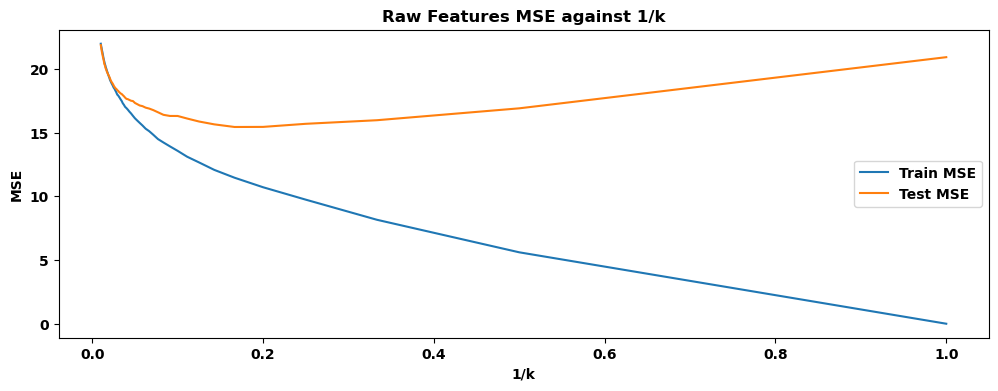

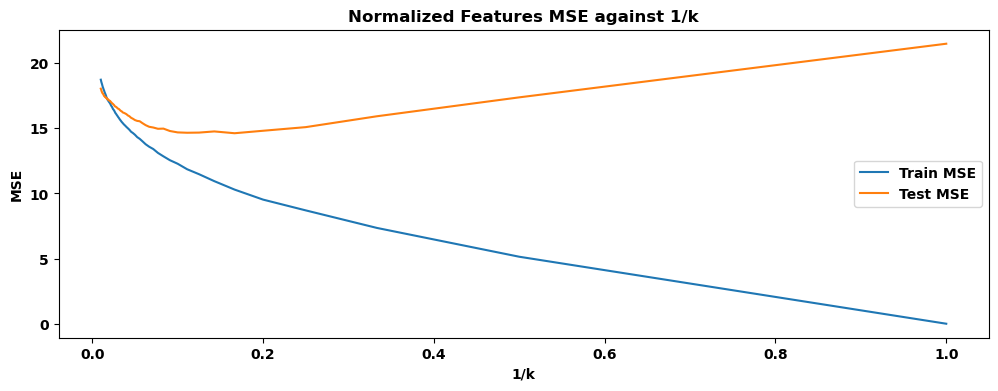

In [42]:
plt.figure()

#Error plot for raw features
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(raw_results[3],raw_results[0],label=results_header[0])
ax.plot(raw_results[3],raw_results[1],label=results_header[1])
plt.xlabel(results_header[3])
plt.ylabel('MSE')
plt.title("Raw Features MSE against 1/k")
plt.legend(loc="center right")

#Error plot for normalized features
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(normalized_results[3],normalized_results[0],label=results_header[0])
ax.plot(normalized_results[3],normalized_results[1],label=results_header[1])
plt.xlabel(results_header[3])
plt.ylabel('MSE')
plt.title("Normalized Features MSE against 1/k")
plt.legend(loc="center right")

plt.show()

**(j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.**

In [43]:
summary_h_df = summary_h_df[['Test Error']]
summary_j_df = pd.concat([summary_h_df, summary_i_df])
summary_j_df = summary_j_df.iloc[2:]
summary_j_df

Test Error
2nd-order Model w/ Backward Elimination   17.381329
KNN on raw features                       15.445303
KNN on normalized features                14.627059

Comparing the results of parts (h) and (i), we find that KNN regression with the normalized features has the lowest test error. This seems expected because normalizing features standardizes their spacing across dimensions, thus giving each features equal weightage as compared to raw features. The stackexchange (link: https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn) has a beautiful diagram illustrating how normalizing fairly spaces out points across dimensions thus giving each dimension equal weight as compared to points being favored if they are clustered in a small range in one dimension but vastly spaced apart in another (I hope I'm making sense here to my reader). This matters because from part b(iii) we saw that the range for AT is 35.3 whereas the range for RH is 74.6, so clearly points would be closer packed together on the AT-axis than the RH axis and normalization allows us to equally scale and weight for both 'fairly' (and the remaining features as well). Note here that we see this result for this specific randomly seeded run, if we rerun the program the results may vary and sometimes raw features does better than normalized features, some contributing reasons could be the noise in the data and the bimodal peaks in features instead of normal distribution/unimodal peaks.

**References**
- Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615, http://dx.doi.org/10.1016/j.ijepes.2014.02.027.
(http://www.sciencedirect.com/science/article/pii/S0142061514000908)
- Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)

**2. ISLR: 2.4.1**
**1. For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.  
(a) The sample size n is extremely large, and the number of predictors p is small.  
(b) The number of predictors p is extremely large, and the number of observations n is small.  
(c) The relationship between the predictors and response is highly non-linear.  
(d) The variance of the error terms, i.e. σ2 = Var(ϵ), is extremely high.**

a)  
Flexible does better, as it would fit the data better than an inflexible approach given the large sample size.  
  
b)  
Flexible does worse, because a flexible model would have many parameters that would allow it to fit to the few observations in order to minimize training error but in the process lead to overfitting of the data.  
  
c)  
Flexible does better, as it will be better able to account for the nonlinearity using the higher number of features available to for fitting (high degrees of freedom).  
  
d)  
Flexible does worse, because it will use the higher degrees of freedom to try and fit to the noise in the error terms, thereby increasing MSE through an increased variance as compared to an inflexible model.

**3. ISLR: 2.4.7** 
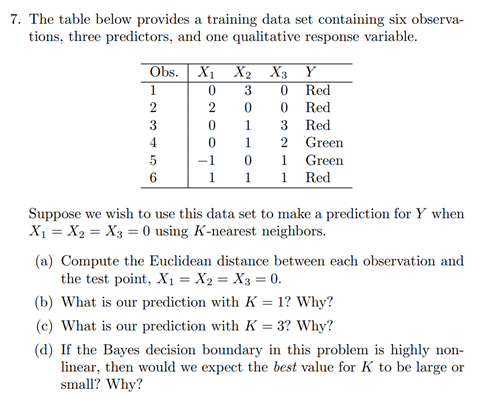

a)  
- $Obs.1 = \sqrt{(0 - 0)^{2} + (3 - 0)^{2} + (0 - 0)^{2} } = 3$

- $Obs.2 = \sqrt{(2 - 0)^{2} + (0 - 0)^{2} + (0 - 0)^{2} } = 2 $

- $Obs.3 = \sqrt{(0 - 0)^{2} + (1 - 0)^{2} + (3 - 0)^{2} } = \sqrt{10} $

- $Obs.4 = \sqrt{(0 - 0)^{2} + (1 - 0)^{2} + (2 - 0)^{2} } = \sqrt{5} $

- $Obs.5 = \sqrt{(-1 - 0)^{2} + (0 - 0)^{2} + (1 - 0)^{2} } = \sqrt{2} $

- $Obs.6 = \sqrt{(1 - 0)^{2} + (1 - 0)^{2} + (1 - 0)^{2} } = \sqrt{3} $
  
b)  
Green will be our prediction, because the nearest neighbor is Obs.5 from the test point and K=1 only considers the nearest neighbor to categorize a point. Since Obs.5 is categorized as green, our model will subsequently predict green for the test point.  
  
c)  
Our prediction is red. When K=3, the closest 3 neighbors are considered in our evaluation, in this that corresponds to Obs. 5, 6 and 2. Now Obs.5 is green, while Obs.2 and 6 are red, so by majority polling, red is the favored choice in prediction here, hence red.  
  
d)  
K should be small, because as the size of K increases the boundary becomes more linear/inflexible, which would be counterproductive to modelling a highly non-linear surface.